In [49]:
import pandas as pd
import matplotlib 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import statsmodels.api as sm 

import numpy as np
import missingno as msno
from google.colab import files
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,normalize
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,recall_score, f1_score, ConfusionMatrixDisplay,confusion_matrix, accuracy_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew,kurtosis
from datetime import datetime

In [50]:
df = pd.read_csv("/content/drive/MyDrive/BeijingPM20100101_20151231.csv")
print(f'Broj opservacija: {df.shape[0]}\nBroj obelezja:{df.shape[1]}')
df.head()

Broj opservacija: 52584
Broj obelezja:18


,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


In [51]:
df.pop("No")
df.rename(columns={"PM_US Post": "pm25", "DEWP": "dew_temp", "HUMI":"humidity","PRES":"air_pressure","TEMP":"temp","cbwd":"wind_direction","Iws":"cumulative_wind_speed","Iprec":"cumulative_precipitation"},inplace = True)
df.describe()

,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,pm25,dew_temp,humidity,air_pressure,temp,cumulative_wind_speed,precipitation,cumulative_precipitation
count,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,25052.000000,20508.000000,24931.000000,50387.000000,52579.000000,52245.000000,52245.000000,52579.000000,52579.000000,52100.000000,52100.000000
mean,2012.499772,6.523962,15.726609,11.500000,2.491100,89.154439,92.560806,88.643737,95.904241,2.074554,54.602421,1016.465442,12.587040,23.261829,19.258683,19.519008
std,1.707485,3.448452,8.798896,6.922252,1.116988,87.239267,88.027434,88.041166,91.643772,14.222059,25.991338,10.295070,12.098527,49.281706,4381.035532,4381.036040
min,2010.000000,1.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,1.000000,-40.000000,2.000000,991.000000,-19.000000,0.450000,0.000000,0.000000
25%,2011.000000,4.000000,8.000000,5.750000,1.000000,24.000000,28.000000,24.000000,27.000000,-10.000000,31.000000,1008.000000,2.000000,1.790000,0.000000,0.000000
50%,2012.000000,7.000000,16.000000,11.500000,2.000000,64.000000,68.000000,62.000000,69.000000,2.000000,55.000000,1016.000000,14.000000,4.920000,0.000000,0.000000
75%,2014.000000,10.000000,23.000000,17.250000,3.000000,124.000000,127.000000,122.000000,132.000000,15.000000,78.000000,1025.000000,23.000000,21.020000,0.000000,0.000000
max,2015.000000,12.000000,31.000000,23.000000,4.000000,737.000000,672.000000,844.000000,994.000000,28.000000,100.000000,1046.000000,42.000000,585.600000,999990.000000,999990.000000


Preimenovanje naziva kolona u citkija imena

In [52]:
df_nulls = df.isnull().sum().rename_axis("Obelezje")
df_nulls = df_nulls.to_frame()
df_nulls.rename(columns = {0:'# nedostajucih podataka'},inplace = True)
df_nulls['% nedostajucih podataka']  = (round(df.isnull().sum() / len(df),4)*100).astype("string") + "%"
df_nulls['% nula vrednosti'] = (round(df.isin([0]).sum() / len(df),4)*100).astype("string") + "%"
df_nulls.sort_values(by = "% nedostajucih podataka",ascending = False)

,# nedostajucih podataka,% nedostajucih podataka,% nula vrednosti
Obelezje,,,
PM_Dongsihuan,32076,61.0%,0.0%
PM_Nongzhanguan,27653,52.59%,0.0%
PM_Dongsi,27532,52.35999999999999%,0.0%
pm25,2197,4.18%,0.0%
precipitation,484,0.9199999999999999%,95.25%
cumulative_precipitation,484,0.9199999999999999%,95.25%
humidity,339,0.64%,0.0%
air_pressure,339,0.64%,0.0%
dew_temp,5,0.01%,2.0500000000000003%


Text(0.5, 1.0, 'Matrica nedostajucih vrednosti')

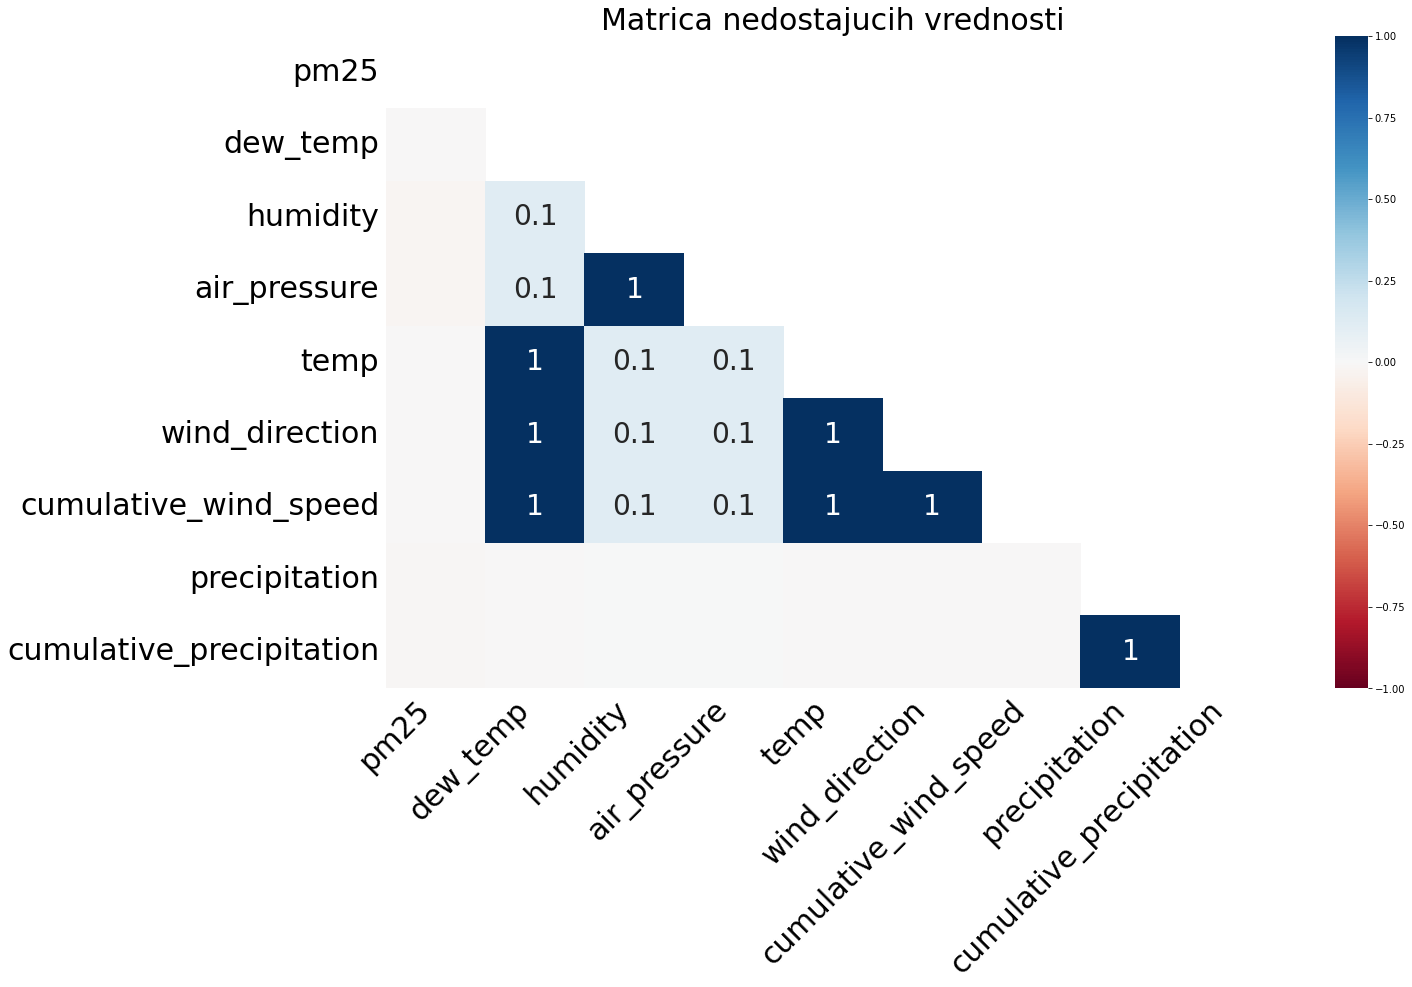

In [53]:
df.drop(["PM_Dongsi","PM_Dongsihuan","PM_Nongzhanguan"], axis=1, inplace = True)
msno.heatmap(df,fontsize = 30)
plt.title('Matrica nedostajucih vrednosti',fontsize = 30)

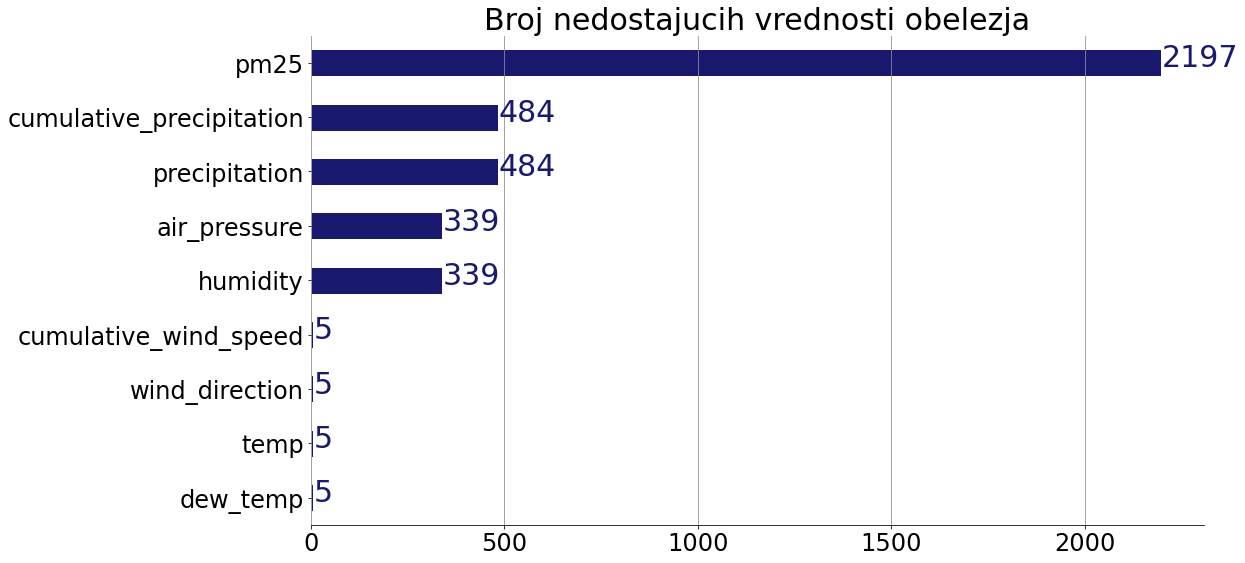

In [54]:
nullValues = df.isnull().sum().sort_values()
nullValues = nullValues[nullValues != 0]

plot = nullValues.plot.barh(figsize = [16,9],fontsize = 24,color='midnightblue',edgecolor='w')
plot.set_title("Broj nedostajucih vrednosti obelezja",fontsize=30)

plot.spines['top'].set_visible(False)
plot.spines['right'].set_visible(False)
plot.spines['left'].set_visible(False)
plot.xaxis.grid(True, color='#8e8e8e')


for i in plot.patches:
  x = i.get_width()+2
  y = i.get_y()+0.175
  plot.text( x,y,str(round((i.get_width()), 2)),fontsize = 30, color = "midnightblue")

uzorcima kojima nedostaje vrednost obelezja temperatura nedostaju i vrednosti za obelezja temperatura rose, pravac vetra, vlaznost vazduha, vazdusni pritisak, kumulativna brzina vetra

In [55]:
df.drop(df[df[['temp','wind_direction','cumulative_wind_speed','dew_temp']].isnull().all(1)].index,inplace = True)

In [56]:
missing_prec_index = df[df['precipitation'].isnull()].index
df['pm25'].fillna(method='ffill',limit = 2, inplace=True)
df['humidity'].fillna(method='ffill',limit = 2, inplace=True)
df['air_pressure'].fillna(method='ffill',limit = 2, inplace=True)
df['precipitation'].fillna(method='ffill',limit = 2, inplace=True)
df.isnull().sum()

year                           0
month                          0
day                            0
hour                           0
season                         0
pm25                        1828
dew_temp                       0
humidity                     326
air_pressure                 326
temp                           0
wind_direction                 0
cumulative_wind_speed          0
precipitation                349
cumulative_precipitation     484
dtype: int64

In [57]:
def maxNumberOfConsecutiveNaNs(feature):
  return df[feature].isnull().astype(int).groupby(df[feature].notnull().astype(int).cumsum()).sum().sort_values().max()

missing_values_columns = list(df_nulls[df_nulls['# nedostajucih podataka'] != 0].sort_values(by = '# nedostajucih podataka',ascending = False).index)
print('Najduzi niz sukcesivnih redova sa nedostajucim vrednostima obelezja')
for feature in missing_values_columns[3:4]:
  print(f'{feature}: {maxNumberOfConsecutiveNaNs(feature)}')


Najduzi niz sukcesivnih redova sa nedostajucim vrednostima obelezja
pm25: 153


In [58]:
df = df.set_index(['month','day'])
pres_filler = pd.DataFrame(df.groupby(['month','day'])['air_pressure'].mean(),columns=["air_pressure"])
humi_filler = pd.DataFrame(df.groupby(['month','day'])['humidity'].mean(),columns=["humidity"])
df.update(pres_filler,overwrite=False)
df.update(humi_filler,overwrite=False)
df.reset_index(inplace = True)


df = df.set_index(['year','month'])
prec_filler = pd.DataFrame(df.groupby(['year','month'])['precipitation'].median(),columns=["precipitation"])
df.update(prec_filler,overwrite=False)
df.reset_index(inplace = True)

cumulative_prec_filler = []
cumulative_sum = 0

#Kumulativna suma padavina se racuna kao suma svih prethodnih vrednosti padavima, dokle god su vrednosti razlicte od nule, u suprotnom se kumulativna suma se resetuje
for index, row in df.iterrows():
    if row['precipitation'] != 0:
        cumulative_sum += row['precipitation']
    else:
        cumulative_sum = 0
    cumulative_prec_filler.append(cumulative_sum)

cumulative_prec_filler = pd.DataFrame(cumulative_prec_filler,columns =['cumulative_precipitation'])
df['cumulative_precipitation'].fillna(cumulative_prec_filler['cumulative_precipitation'],inplace = True)

df.isnull().sum()
    

year                           0
month                          0
day                            0
hour                           0
season                         0
pm25                        1828
dew_temp                       0
humidity                       0
air_pressure                   0
temp                           0
wind_direction                 0
cumulative_wind_speed          0
precipitation                  0
cumulative_precipitation       0
dtype: int64

In [59]:
print("Pre popunjavanja NAN vrednosti:\n",df['pm25'].describe(),"\n")
pm25 = df.groupby(['month','day'])['pm25'].median().reset_index()
pm25.rename(columns={'pm25': 'pm_median'}, inplace=True)

df = pd.merge(df, pm25, how='left', on=['month','day'])
df.loc[df['pm25'].isna(),'pm25'] = df['pm_median']
df.pop("pm_median")
print("Posle popunjavanja NAN vrednosti:\n",df['pm25'].describe())

Pre popunjavanja NAN vrednosti:
 count    50751.000000
mean        95.898642
std         91.738536
min          1.000000
25%         27.000000
50%         69.000000
75%        132.000000
max        994.000000
Name: pm25, dtype: float64 

Posle popunjavanja NAN vrednosti:
 count    52579.000000
mean        95.130071
std         90.433497
min          1.000000
25%         28.000000
50%         69.000000
75%        130.000000
max        994.000000
Name: pm25, dtype: float64


In [60]:
print(df.shape,'\n')
print(df.isnull().sum())

(52579, 14) 

year                        0
month                       0
day                         0
hour                        0
season                      0
pm25                        0
dew_temp                    0
humidity                    0
air_pressure                0
temp                        0
wind_direction              0
cumulative_wind_speed       0
precipitation               0
cumulative_precipitation    0
dtype: int64


In [61]:
print('Dinamicki opseg:\n\n',(df.describe().loc['max'] -df.describe().loc['min'])[5:])
print('IQR:\n\n', (df.describe().loc['75%'] -df.describe().loc['25%'])[5:])

Dinamicki opseg:

 pm25                           993.00
dew_temp                        68.00
humidity                        98.00
air_pressure                    55.00
temp                            61.00
cumulative_wind_speed          585.15
precipitation               999990.00
cumulative_precipitation    999990.00
dtype: float64
IQR:

 pm25                        102.00
dew_temp                     25.00
humidity                     46.00
air_pressure                 17.00
temp                         21.00
cumulative_wind_speed        19.23
precipitation                 0.00
cumulative_precipitation      0.00
dtype: float64


In [62]:
df.drop(df[df.precipitation == 999990.00].index, inplace = True)
df.shape

(52578, 14)

<Figure size 432x288 with 0 Axes>

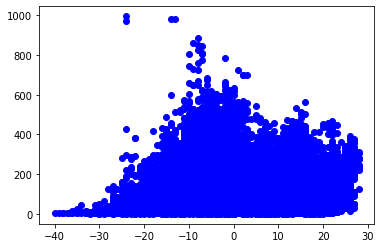

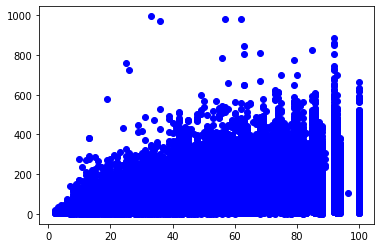

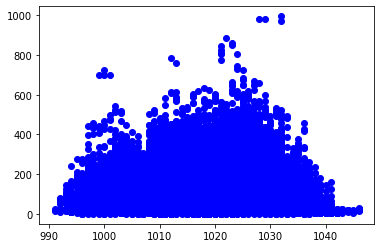

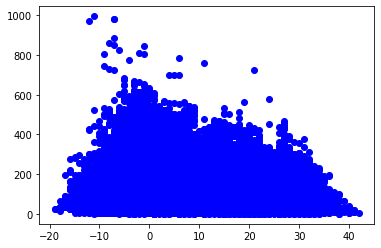

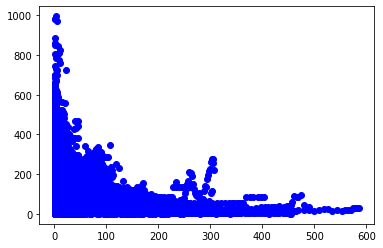

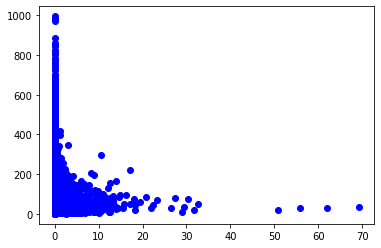

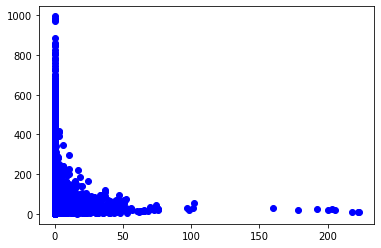

<Figure size 432x288 with 0 Axes>

In [63]:

plt.scatter(df['dew_temp'], df['pm25'], color = 'blue')
plt.figure()
#primetna pozitivna korelacija iymedju obelezja pm25 i humidity
plt.scatter(df['humidity'], df['pm25'], color = 'blue')
plt.figure()

plt.scatter(df['air_pressure'], df['pm25'], color = 'blue')
plt.figure()

plt.scatter(df['temp'], df['pm25'], color = 'blue')
plt.figure()

plt.scatter(df['cumulative_wind_speed'], df['pm25'], color = 'blue')
plt.figure()

plt.scatter(df['precipitation'], df['pm25'], color = 'blue')
plt.figure()

plt.scatter(df['cumulative_precipitation'], df['pm25'], color = 'blue')
plt.figure()

In [64]:
# df['evening'] = ((df['hour'] > 16).astype(int))
# df1 = df.copy()
# df1.index = pd.to_datetime(df.year*1000000 + df.month*10000 + df.day*100 + df.hour, format='%Y%m%d%H')
# df['weekend'] = ((df1.index.weekday > 4).astype(int))
# df.head()

In [65]:
df1 = df.copy()
df1.index = pd.to_datetime(df.year*1000000 + df.month*10000 + df.day*100 + df.hour, format='%Y%m%d%H')
df1.head()

,year,month,day,hour,season,pm25,dew_temp,humidity,air_pressure,temp,wind_direction,cumulative_wind_speed,precipitation,cumulative_precipitation
2010-01-01 00:00:00,2010,1,1,0,4,31.0,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
2010-01-01 01:00:00,2010,1,1,1,4,31.0,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2010-01-01 02:00:00,2010,1,1,2,4,31.0,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
2010-01-01 03:00:00,2010,1,1,3,4,31.0,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
2010-01-01 04:00:00,2010,1,1,4,4,31.0,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


Dnevne srednje vrednosti vazdusnog pritska i vlaznosti vazduha se svake godine krecu u istom opsegu. Takodje, moze se primetiti da su grafici lice na periodicne signale, sa periodom duzine od oko godinu dana.

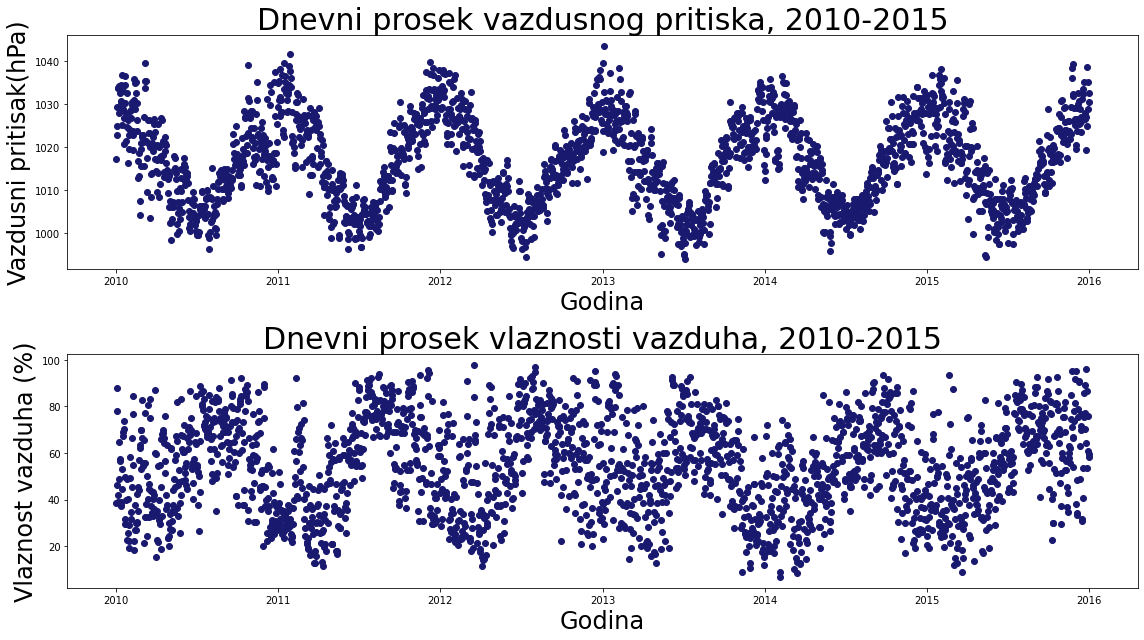

In [66]:
plt.figure(figsize = [16,9])
plt.subplot(2,1,1)
plt.scatter(x = df1.air_pressure.resample('D').mean().index, y = df1.air_pressure.resample('D').mean(),color='midnightblue')
plt.xlabel('Godina',  fontsize=24)
plt.ylabel('Vazdusni pritisak(hPa)',fontsize=24)
plt.title('Dnevni prosek vazdusnog pritiska, 2010-2015',fontsize=30)

plt.subplot(2,1,2)
plt.scatter(x = df1.humidity.resample('D').mean().index, y = df1.humidity.resample('D').mean(),color='midnightblue')
plt.xlabel('Godina',fontsize=24)
plt.ylabel('Vlaznost vazduha (%)',fontsize=24)
plt.title('Dnevni prosek vlaznosti vazduha, 2010-2015',fontsize=30)

plt.tight_layout()



Veliki broj nula vrednosti kolicine padavina.Pogotov u toku zime, sto je i ocekivano.

Text(0.5, 1.0, 'Dnevni prosek kolicine padavina, 2010-2015')

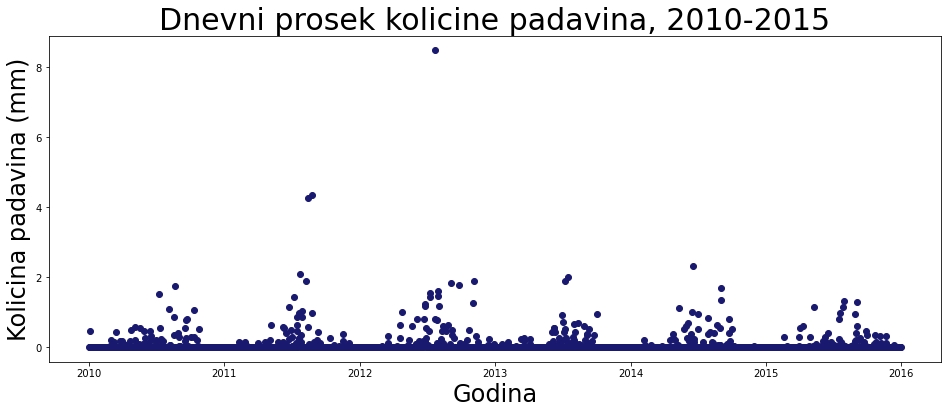

In [67]:
plt.figure(figsize = [16,6])
plt.scatter(x = df1.precipitation.resample('D').mean().index, y = df1.precipitation.resample('D').mean(),color='midnightblue')
plt.xlabel('Godina',  fontsize=24)
plt.ylabel('Kolicina padavina (mm)',fontsize=24)
plt.title('Dnevni prosek kolicine padavina, 2010-2015',fontsize=30)


Text(0.5, 1.0, 'Odnos temperature i vlaznosti, 2010-2015')

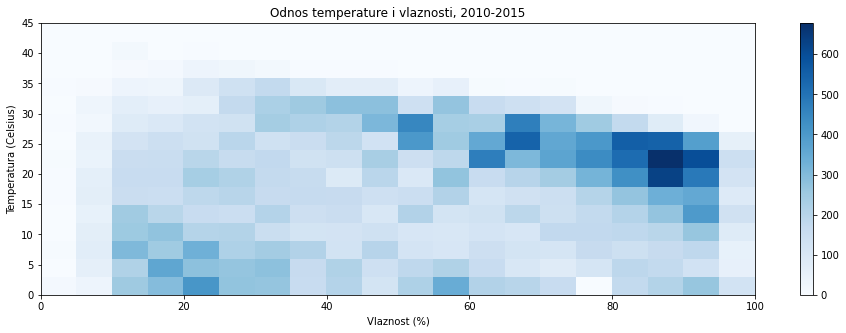

In [68]:
plt.figure(figsize = [16,5])
plt.hist2d(x = df1.humidity, y = df1.temp, bins = (20, 15), range = ((0,100),(0,45)), cmap = 'Blues')
plt.colorbar()
plt.xlabel('Vlaznost (%)')
plt.ylabel('Temperatura (Celsius)')
plt.title('Odnos temperature i vlaznosti, 2010-2015')

##Analiza izlazne promenljive

Primetno siri interkvartilni opseg koncentracije pm25 cestica zimi. Visa medijana u odnosu na druga godisnja doba,vrlo moguce prouzrokovana spaljivanjem  uglja za potrebe grejanja. Kina godinama unazad najveci potrosac uglja(skoro toliki, da godisnje potrosi vise uglja od svih drugih zemlje kombinovano). 

In [69]:
spring_description = df[df['season'] == 1].describe()['pm25']
summer_description = df[df['season'] == 2].describe()['pm25']
fall_description = df[df['season'] == 3].describe()['pm25']
winter_description = df[df['season'] == 4].describe()['pm25']

print("Prolece IQR:\t",spring_description.loc['75%']-spring_description.loc['25%'])
print("Leto IQR:\t",summer_description.loc['75%']-summer_description.loc['25%'])
print("Jesen IQR:\t",fall_description.loc['75%']-fall_description.loc['25%']) 
print("Zima IQR:\t",winter_description.loc['75%']-winter_description.loc['25%'])

Prolece IQR:	 86.0
Leto IQR:	 77.0
Jesen IQR:	 118.0
Zima IQR:	 141.0


[Text(0, 0, 'spring'),
 Text(0, 0, 'summer'),
 Text(0, 0, 'fall'),
 Text(0, 0, 'winter')]

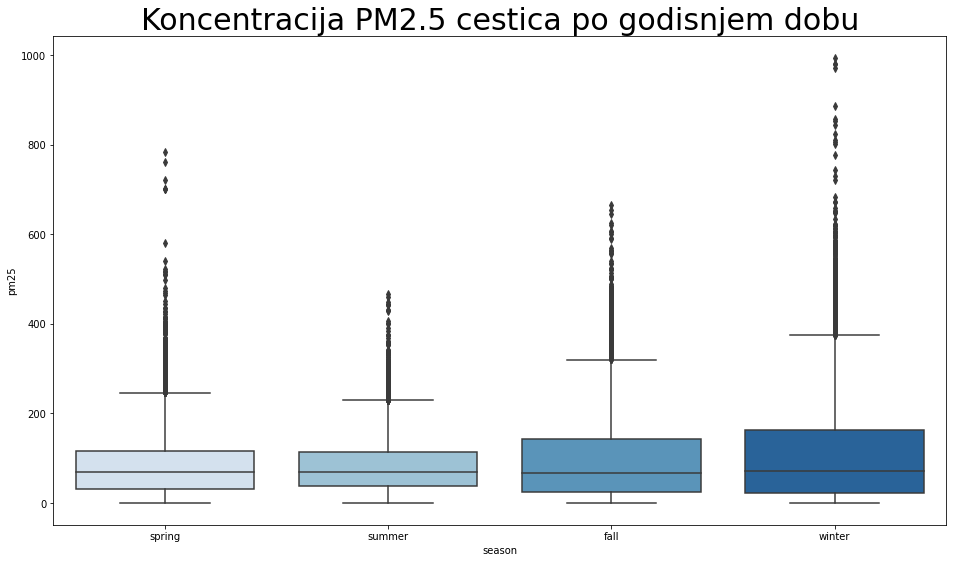

In [70]:
df[df['season'] == 4]['pm25']
df.groupby('season')[['pm25']].mean()
plt.figure(figsize = [16,9])
plt.title('Koncentracija PM2.5 cestica po godisnjem dobu',fontsize = 30)
ax = sns.boxplot(x="season",y= "pm25",data = df,palette = "Blues")
ax.set_xticklabels(['spring','summer','fall','winter'])

Text(0, 0.5, 'Koncentracija PM 2.5 cestica (μg/m3)')

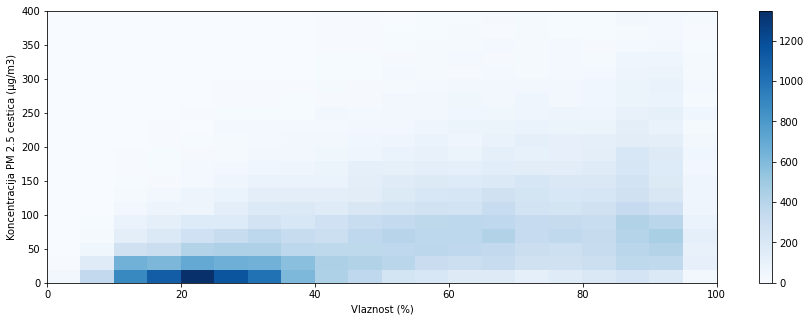

In [71]:
plt.figure(figsize = [15,5])
plt.hist2d(x = df1.humidity, y = df1['pm25'], bins = (20, 20), range = ((0,100),(0,400)), cmap = 'Blues')
plt.colorbar()
plt.xlabel('Vlaznost (%)')
plt.ylabel('Koncentracija PM 2.5 cestica (μg/m3)')

In [72]:
del df1

In [73]:
#one-hot enkodovanje obelezja season
temp = df.drop(columns = ['season'])
x_temp = pd.get_dummies(df['season'], prefix = 'season')
x_temp = x_temp.rename(columns = {'season_1': 'spring', 'season_2':'summer', 'season_3': 'fall'})
df = pd.concat([temp,x_temp.iloc[:,:-1]], axis = 1)

In [74]:
numeric_features = df[["pm25","dew_temp","humidity","air_pressure","temp","cumulative_wind_speed","precipitation","cumulative_precipitation"]]
categorical_features = df[["pm25","year","month","day","hour","wind_direction","spring","summer","fall"]]
print(f'Numericka obelezja: {list(numeric_features.columns)}\nKategoricka obelezja: {list(categorical_features.columns)}')

Numericka obelezja: ['pm25', 'dew_temp', 'humidity', 'air_pressure', 'temp', 'cumulative_wind_speed', 'precipitation', 'cumulative_precipitation']
Kategoricka obelezja: ['pm25', 'year', 'month', 'day', 'hour', 'wind_direction', 'spring', 'summer', 'fall']


Text(0.5, 1.0, 'Matrica korelacije')

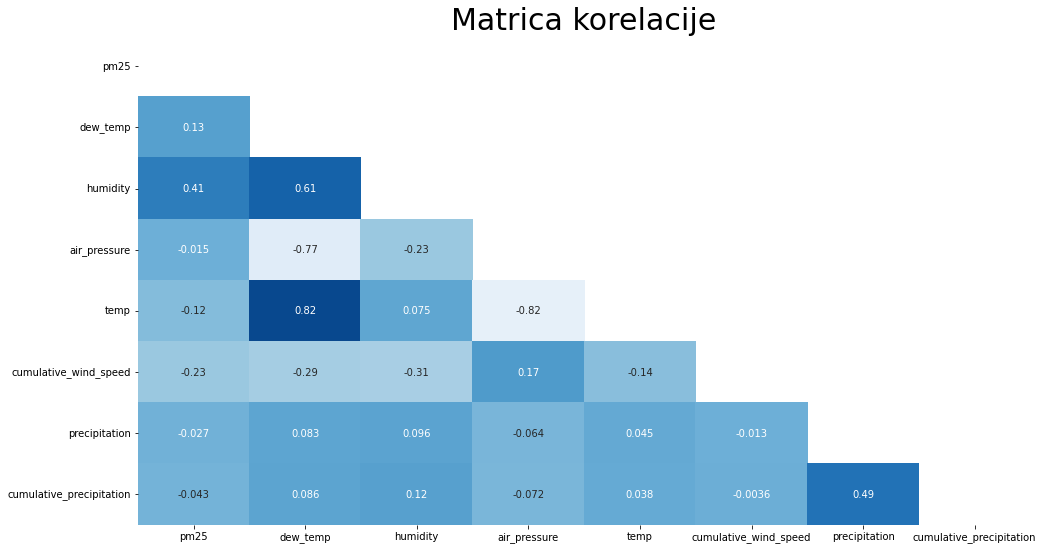

In [75]:
#matrica korelacije
plt.figure(figsize= (16,9))
corr = numeric_features.corr()
matrix = np.triu(corr)
heatmap = sns.heatmap(corr, vmin = -1, vmax = 1, annot = True, cmap = 'Blues',cbar=False, mask = matrix)
heatmap.set_title('Matrica korelacije', fontdict = {'fontsize':30})

Text(0.5, 0, 'kumulativna kolicina padavina')

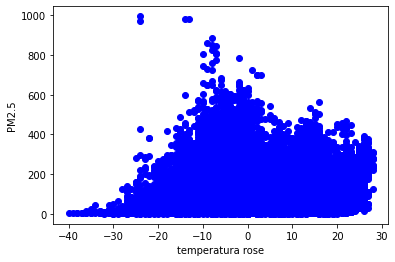

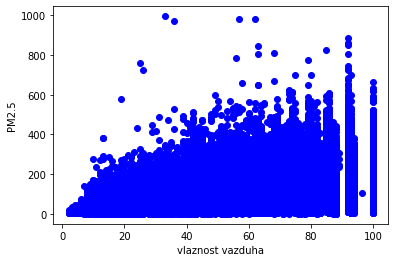

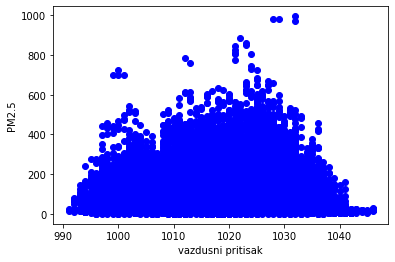

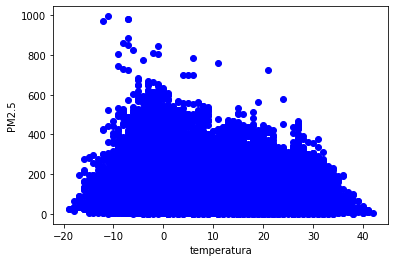

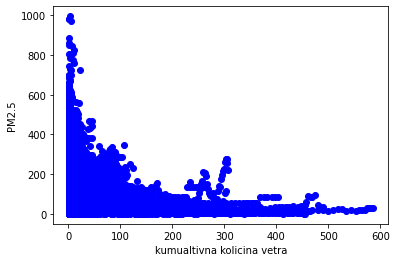

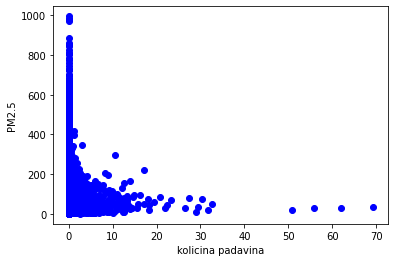

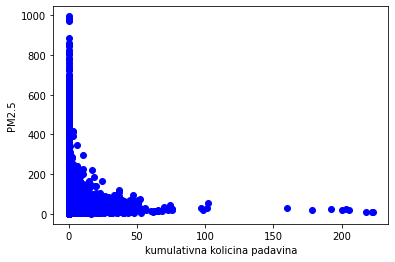

In [160]:
#pregled korelacije izmedju PM25 i ostalih obelezja
plt.figure()
plt.scatter(df['dew_temp'],df['pm25'], color = 'blue')
plt.ylabel('PM2.5')
plt.xlabel('temperatura rose')

plt.figure()
plt.scatter(df['humidity'],df['pm25'], color = 'blue')
plt.ylabel('PM2.5')
plt.xlabel('vlaznost vazduha')

plt.figure()
plt.scatter(df['air_pressure'],df['pm25'], color = 'blue')
plt.ylabel('PM2.5')
plt.xlabel('vazdusni pritisak')

plt.figure()
plt.scatter(df['temp'],df['pm25'], color = 'blue')
plt.ylabel('PM2.5')
plt.xlabel('temperatura')

plt.figure()
plt.scatter(df['cumulative_wind_speed'],df['pm25'], color = 'blue')
plt.ylabel('PM2.5')
plt.xlabel('kumualtivna kolicina vetra')

plt.figure()
plt.scatter(df['precipitation'],df['pm25'], color = 'blue')
plt.ylabel('PM2.5')
plt.xlabel('kolicina padavina')

plt.figure()
plt.scatter(df['cumulative_precipitation'],df['pm25'], color = 'blue')
plt.ylabel('PM2.5')
plt.xlabel('kumulativna kolicina padavina')


In [76]:
skewness = df[list(numeric_features.columns)].apply(lambda i: skew(i))
krtosis = df[list(numeric_features.columns)].apply(lambda i: kurtosis(i))
print('Koeficijent asimetricnosti: ')
print(skewness,'\n')
print('Koeficijent spljostenosti: ')
print(krtosis)

Koeficijent asimetricnosti: 
pm25                         1.925802
dew_temp                    -0.172361
humidity                    -0.031275
air_pressure                 0.099278
temp                        -0.158721
cumulative_wind_speed        4.399105
precipitation               38.110618
cumulative_precipitation    30.597536
dtype: float64 

Koeficijent spljostenosti: 
pm25                           5.489079
dew_temp                      -1.173517
humidity                      -1.212444
air_pressure                  -0.849132
temp                          -1.116057
cumulative_wind_speed         24.489320
precipitation               2203.868278
cumulative_precipitation    1373.235037
dtype: float64


Najvece zagadjenje na Lunarnu novu godinu



In [77]:
df.sort_values(by=['pm25'],ascending=False).head(15)

,year,month,day,hour,pm25,dew_temp,humidity,air_pressure,temp,wind_direction,cumulative_wind_speed,precipitation,cumulative_precipitation,spring,summer,fall
18048,2012,1,23,0,994.0,-24.0,33.0,1032.0,-11.0,NW,3.13,0.0,0.0,0,0,0
1056,2010,2,14,0,980.0,-13.0,62.0,1028.0,-7.0,NE,0.89,0.0,0.0,0,0,0
1057,2010,2,14,1,980.0,-14.0,57.0,1029.0,-7.0,cv,0.89,0.0,0.0,0,0,0
18049,2012,1,23,1,972.0,-24.0,36.0,1032.0,-12.0,NW,4.92,0.0,0.0,0,0,0
26587,2013,1,12,19,886.0,-8.0,92.0,1022.0,-7.0,cv,0.89,0.0,0.0,0,0,0
26589,2013,1,12,21,858.0,-9.0,92.0,1023.0,-8.0,NE,0.89,0.0,0.0,0,0,0
26588,2013,1,12,20,852.0,-8.0,92.0,1023.0,-7.0,cv,1.34,0.0,0.0,0,0,0
26583,2013,1,12,15,845.0,-7.0,63.0,1021.0,-1.0,SE,7.16,0.0,0.0,0,0,0
26586,2013,1,12,18,824.0,-8.0,85.0,1021.0,-6.0,SE,11.63,0.0,0.0,0,0,0
26584,2013,1,12,16,810.0,-7.0,68.0,1021.0,-2.0,SE,8.95,0.0,0.0,0,0,0


Text(69, 34500, '  Medijana = 69.0')

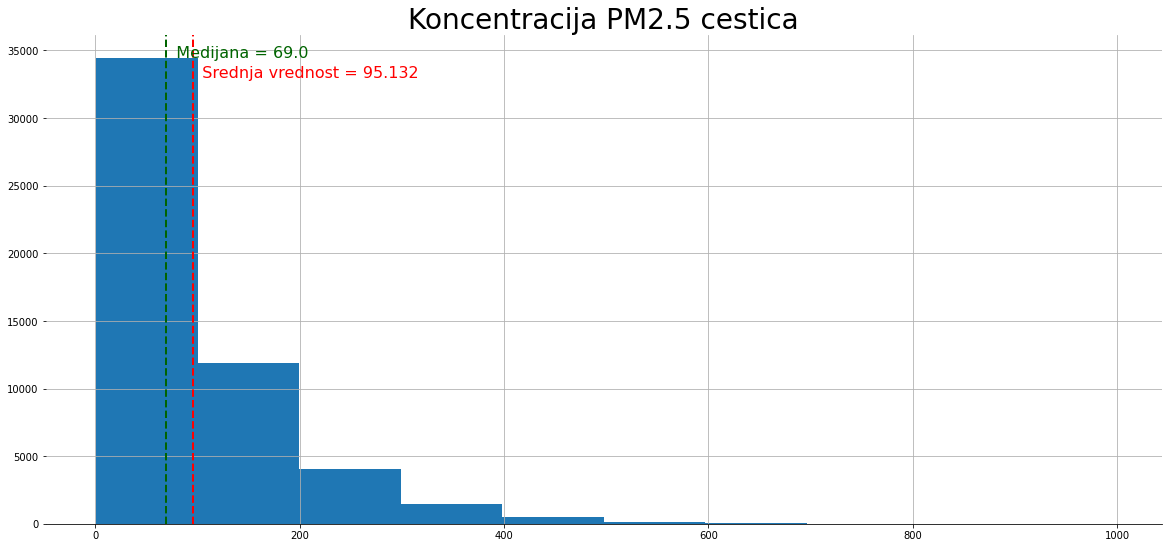

In [78]:
plot = df['pm25'].hist(figsize=[20,9],bins = 10)
plt.title('Koncentracija PM2.5 cestica',fontsize = 28)
plt.axvline(df['pm25'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(df['pm25'].median(), color = 'darkgreen', linestyle = 'dashed',linewidth = 2)
plot.spines['top'].set_visible(False)
plot.spines['right'].set_visible(False)

plot.spines['top'].set_visible(False)
plot.spines['right'].set_visible(False)
plot.spines['left'].set_visible(False)
plt.text(95, 33000, '  Srednja vrednost = ' + str(round(df['pm25'].mean(),3)), color = 'red',fontsize = 16)
plt.text(69, 34500, '  Medijana = ' + str(round(df['pm25'].median(),3)), color = 'darkgreen',fontsize = 16)

                      pm25
wind_direction            
NW               63.987318
NE               87.222033
SE              108.335541
cv              123.893665


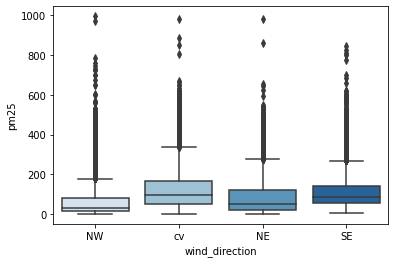

In [79]:
groupedByWindDirection = df.groupby('wind_direction')[['pm25']].mean().sort_values(by=['pm25'])
print(groupedByWindDirection)
#75-i percetil najveci kod grupe cv- mirnog/promenljivog vetra. Najveci dinamicki opseg kod grupe NW- severozapadno
sns.boxplot(x="wind_direction",y= "pm25",data = df,palette = "Blues")

In [80]:
#kodovanje pravca duvanja vetra
for i in range(0, groupedByWindDirection.shape[0]):
    df.loc[df['wind_direction'] == groupedByWindDirection.index[i], 'wind_direction'] = i
df['wind_direction'] = df['wind_direction'].astype(int)  
df.head()

,year,month,day,hour,pm25,dew_temp,humidity,air_pressure,temp,wind_direction,cumulative_wind_speed,precipitation,cumulative_precipitation,spring,summer,fall
0,2010,1,1,0,31.0,-21.0,43.0,1021.0,-11.0,0,1.79,0.0,0.0,0,0,0
1,2010,1,1,1,31.0,-21.0,47.0,1020.0,-12.0,0,4.92,0.0,0.0,0,0,0
2,2010,1,1,2,31.0,-21.0,43.0,1019.0,-11.0,0,6.71,0.0,0.0,0,0,0
3,2010,1,1,3,31.0,-21.0,55.0,1019.0,-14.0,0,9.84,0.0,0.0,0,0,0
4,2010,1,1,4,31.0,-20.0,51.0,1018.0,-12.0,0,12.97,0.0,0.0,0,0,0


In [81]:
#one-hot kodovanje obelezja godina
temp = df.drop(columns = ['year'])
x_temp = pd.get_dummies(df['year'], prefix = 'year')
df = pd.concat([temp,x_temp.iloc[:,:-1]], axis = 1)

#one-hot kodovanje obelezja mesec
temp = df.drop(columns = ['month'])
x_temp = pd.get_dummies(df['month'], prefix = 'month')
df = pd.concat([temp,x_temp.iloc[:,:-1]], axis = 1)

In [82]:
#evaluacija modela
def model_evaluation(y_test, y_predicted,N, d,print_results = True):
    mse = mean_squared_error(y_test, y_predicted) 
    mae = mean_absolute_error(y_test, y_predicted) 
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_predicted)
    r2_adj = 1-(1-r2)*(N-1)/(N-d-1)
    rss = np.sum((y_test-y_predicted)**2)
    if print_results:
      print('Mean squared error: ', mse)
      print('Mean absolute error: ', mae)
      print('Root mean squared error: ', rmse)
      print('R2 score: ', r2)
      print('R2 adjusted score: ', r2_adj)
      print('RSS', rss)
      res=pd.concat([pd.DataFrame(y_test .values), pd.DataFrame(y_predicted)], axis=1)
      res.columns = ['y', 'y_pred']
      print(res.head(20))
    return mse,mae,rmse,r2,r2_adj,rss

#Linearna regresija 

In [83]:
# print(df[df['weekend'] == 0].describe()['pm25'],'\n')
# print(df[df['weekend'] == 1].describe()['pm25'])

In [84]:
# df['afternoon'] = ((df['hour'] > 15).astype(int))
# sns.boxplot(x = df['afternoon'],y = df['pm25'])

In [85]:
print(df.shape)
df.isnull().sum()

(52578, 30)


day                         0
hour                        0
pm25                        0
dew_temp                    0
humidity                    0
air_pressure                0
temp                        0
wind_direction              0
cumulative_wind_speed       0
precipitation               0
cumulative_precipitation    0
spring                      0
summer                      0
fall                        0
year_2010                   0
year_2011                   0
year_2012                   0
year_2013                   0
year_2014                   0
month_1                     0
month_2                     0
month_3                     0
month_4                     0
month_5                     0
month_6                     0
month_7                     0
month_8                     0
month_9                     0
month_10                    0
month_11                    0
dtype: int64

In [86]:
x = df.drop(['pm25'], axis = 1)
y = df['pm25']

#15 % of the dataset
fiftheen_percent = round(df.shape[0] * 0.15)

In [87]:
x.head()

,day,hour,dew_temp,humidity,air_pressure,temp,wind_direction,cumulative_wind_speed,precipitation,cumulative_precipitation,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
0,1,0,-21.0,43.0,1021.0,-11.0,0,1.79,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,-21.0,47.0,1020.0,-12.0,0,4.92,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,-21.0,43.0,1019.0,-11.0,0,6.71,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,-21.0,55.0,1019.0,-14.0,0,9.84,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,-20.0,51.0,1018.0,-12.0,0,12.97,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
#standardizacija
def std(x_train, x_test):
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_std = scaler.transform(x_train)
    x_test_std = scaler.transform(x_test)
    x_train_std = pd.DataFrame(x_train_std)
    x_test_std = pd.DataFrame(x_test_std)
    x_train_std.columns = list(x.columns)
    x_test_std.columns = list(x.columns)
    return x_train_std, x_test_std

def PolyFeat(x_train_std, x_test_std, degree,interaction_only = False,print_feature_names = False):
    #degree default == 2
    poly = PolynomialFeatures(degree = degree,interaction_only = interaction_only, include_bias=False)
    x_inter_train = poly.fit_transform(x_train_std)
    x_inter_test = poly.transform(x_test_std)
    if print_feature_names:
      print(poly.get_feature_names(),poly.n_output_features_)
    return x_inter_train, x_inter_test

In [89]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size = fiftheen_percent, random_state = 48)

x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = fiftheen_percent, random_state = 48)
x_train_std, x_val_std = std(x_train, x_val)

In [90]:
#prag od 0.01,
X = sm.add_constant(x_train)
model = sm.OLS(y_train, X.astype(float)).fit()
model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   pm25   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     969.0
Date:                Mon, 09 Jan 2023   Prob (F-statistic):               0.00
Time:                        17:47:52   Log-Likelihood:            -2.0850e+05
No. Observations:               36804   AIC:                         4.170e+05
Df Residuals:                   36777   BIC:                         4.173e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     1577.0144     77.243     20.416      0.000    1425.616    1728.413
day                          0.4256      0.041     10.256      0.000       0.344       0.507
hour                         0.7671      0.057     13.356      0.000       0.655       0.880
dew_temp                     1.3195      0.167      7.915      0.000       0.993       1.646
humidity                     1.8915      0.052     36.491      0.000       1.790       1.993
air_pressure                -1.5372      0.075    -20.506      0.000      -1.684      -1.390
temp                         3.0800      0.171     18.033      0.000       2.745       3.415
wind_direction              11.1286      0.356     31.238      0.000      10.430      11.827
cumulative_wind_speed       -0.0754      0.008     -9.022      0.000      -0.092      -0.059
precipitation               -1.2303      0.462     -2.662      0.008      -2.136      -0.324
cumulative_precipitation    -1.5823      0.111    -14.266      0.000      -1.800      -1.365
spring                     -78.7864      1.504    -52.398      0.000     -81.734     -75.839
summer                    -175.0987      2.296    -76.271      0.000    -179.598    -170.599
fall                       -90.5398      1.555    -58.226      0.000     -93.588     -87.492
year_2010                   30.2731      1.278     23.685      0.000      27.768      32.778
year_2011                   23.7745      1.262     18.842      0.000      21.301      26.248
year_2012                   13.6685      1.275     10.721      0.000      11.170      16.167
year_2013                   29.1269      1.273     22.874      0.000      26.631      31.623
year_2014                   24.1747      1.264     19.130      0.000      21.698      26.652
month_1                     18.3629      1.777     10.331      0.000      14.879      21.847
month_2                      5.1428      1.833      2.806      0.005       1.551       8.735
month_3                     35.0122      1.155     30.305      0.000      32.748      37.277
month_4                    -28.4321      1.158    -24.554      0.000     -30.702     -26.162
month_5                    -85.3665      1.503    -56.796      0.000     -88.313     -82.421
month_6                    -37.5067      1.219    -30.779      0.000     -39.895     -35.118
month_7                    -66.1850      1.360    -48.681      0.000     -68.850     -63.520
month_8                    -71.4069      1.304    -54.763      0.000     -73.963     -68.851
month_9                   -108.1063      1.558    -69.394      0.000    -111.160    -105.053
month_10                   -22.5580      1.175    -19.190      0.000     -24.862     -20.254
month_11                    40.1245      1.174     34.174      0.000      37.823      42.426
==============

In [91]:
y_train_val.shape

(44691,)

In [92]:
#linearna regresija bez regularizacije
def LinRegression(x_train, y_train,x_val,y_val,plot_coef = True):
    first_regression_model = LinearRegression(fit_intercept=True)
    first_regression_model.fit(x_train, y_train)
    y_predicted = first_regression_model.predict(x_val)
    model_evaluation(y_val, y_predicted, x_train.shape[0], x_train.shape[1])
    if plot_coef:
      plt.figure(figsize=(10,5))
      plt.bar(range(len(first_regression_model.coef_)),first_regression_model.coef_)
    print("koeficijenti: ", first_regression_model.coef_)

In [93]:
x_train_val_std, x_test_std = std(x_train_val, x_test)

In [94]:
print(x_train_val_std.shape)
print(x_test.shape)
print(y_test.shape)
x_train_val_std.head()


(44691, 29)
(7887, 29)
(7887,)


,day,hour,dew_temp,humidity,air_pressure,temp,wind_direction,cumulative_wind_speed,precipitation,cumulative_precipitation,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
0,-0.877981,-0.219535,-1.338503,-0.829877,1.116298,-1.288426,-1.273771,0.236450,-0.072931,-0.083862,...,-0.289322,-0.304098,-0.299553,-0.305458,-0.297152,-0.303835,-0.303835,-0.300085,-0.303747,-0.300439
1,1.165538,-1.231913,-0.003301,0.982293,0.824569,-0.627011,1.336680,-0.445920,-0.072931,-0.083862,...,-0.289322,-0.304098,-0.299553,-0.305458,-0.297152,-0.303835,-0.303835,-0.300085,3.292214,-0.300439
2,0.597894,-1.665789,-1.549325,-0.868434,2.088728,-1.536457,-1.273771,1.063923,-0.072931,-0.083862,...,-0.289322,-0.304098,-0.299553,-0.305458,-0.297152,-0.303835,-0.303835,-0.300085,-0.303747,-0.300439
3,1.733183,-0.074910,0.839985,-0.598537,-1.412020,1.357234,1.336680,-0.391379,-0.072931,-0.083862,...,-0.289322,-0.304098,-0.299553,3.273778,-0.297152,-0.303835,-0.303835,-0.300085,-0.303747,-0.300439
4,-0.877981,1.226719,-0.776313,-1.369673,-0.147861,0.117081,0.466530,0.836602,-0.072931,-0.083862,...,-0.289322,-0.304098,3.338307,-0.305458,-0.297152,-0.303835,-0.303835,-0.300085,-0.303747,-0.300439


In [95]:
def RidgeImp(x_train, y_train,x_test,y_test, alpha,plot_coef = True):
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(x_train, y_train)
    y_predicted = ridge_model.predict(x_test)
    mse,mae,rmse,r2,r2_adj,rss = model_evaluation(y_test, y_predicted, x_train.shape[0], x_train.shape[1],False)
    if plot_coef:
      plt.figure(figsize=(10,5))
      plt.bar(range(len(ridge_model.coef_)),ridge_model.coef_)
    return {"mse":mse, "mae":mae,"rmse":rmse,"r2":r2,"r2_adj":r2_adj,"rss":rss}
    #print("koeficijenti: ", ridge_model.coef_)

def LassoImp(x_train, y_train,x_test,y_test, alpha,plot_coef = True):
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(x_train, y_train)
    y_predicted = lasso_model.predict(x_test)
    mse,mae,rmse,r2,r2_adj,rss = model_evaluation(y_test, y_predicted, x_train.shape[0], x_train.shape[1],False)
    if plot_coef:
      plt.figure(figsize=(10,5))
      plt.bar(range(len(lasso_model.coef_)),lasso_model.coef_)
    print(f"Lasso(alpha = {alpha}) je selektovao {sum(lasso_model.coef_ != 0)} obelezja,a odbacio {sum(lasso_model.coef_ == 0)} obelezja")
    return {"mse":mse, "mae":mae,"rmse":rmse,"r2":r2,"r2_adj":r2_adj,"rss":rss}
    #print("koeficijenti: ", lasso_model.coef_)

In [96]:
def train_models(x_train, y_train,x_test,y_test,alphas,model_name,plot_coef = False):
  results = {}
  for alpha in alphas:
    if model_name == 'ridge':
      results[alpha] = RidgeImp(x_train, y_train,x_test,y_test, alpha, plot_coef)
    elif model_name == 'lasso':
      results[alpha] = LassoImp(x_train, y_train,x_test,y_test, alpha, plot_coef)
  return results

#Hipoteza  h<sub>1</sub>(**x**)
h<sub>1</sub>(**x**) = $\theta_0 + \theta_1 * x_1 + \theta_2 * x_2 + ... + \theta_n * x_n$

In [241]:
LinRegression(x_train_val_std,y_train_val,x_test_std,y_test,plot_coef=False)

Mean squared error:  4565.131077453154
Mean absolute error:  49.07540412932811
Root mean squared error:  67.56575373259115
R2 score:  0.41185211893412765
R2 adjusted score:  0.41147021327704625
RSS 36005188.807873026
        y      y_pred
0    29.0   97.056072
1    20.0  105.431072
2   164.0  180.776775
3    14.0   82.360760
4    17.0   77.993572
5   129.0  159.548260
6    65.0   99.837322
7   338.0  196.495525
8     7.0  -42.100178
9    81.0   82.149822
10  113.0  138.259197
11  172.0  161.759197
12  158.0  114.790447
13  204.0  129.399822
14  129.0  140.931072
15   11.0   25.774822
16   50.0   95.524822
17   13.0   43.540447
18  132.0  101.415447
19  150.0  203.673260
koeficijenti:  [ 3.87981255e+00  5.29029320e+00  1.96957787e+01  4.83669311e+01
 -1.64141231e+01  3.59948393e+01  1.24779862e+01 -4.05887708e+00
 -1.19013490e+00 -6.21651554e+00  7.96208666e+12 -8.05852360e+12
  5.56675616e+13  1.08542512e+01  8.74084706e+00  4.76817414e+00
  1.08383014e+01  8.60816180e+00  5.12035106e+

#Hipoteza  h<sub>2</sub>(**x**)
h<sub>2</sub>(**x**) = $\theta_0 + \theta_1 * x_1 + \theta_2 * x_2 + ... + \theta_n * x_n + \theta_{n+1} * x_1x_2 + \theta_{n+2} * x_1x_3 + ... + \theta_{2n-1} * x_{n-2}x_{n-1} + \theta_{2n} * x_{n-1}x_n$

In [242]:
x_inter_train, x_inter_val = PolyFeat(x_train_std, x_val_std, 2)

In [243]:
print(x_inter_train.shape)
print(y_train.shape)
print(x_inter_val.shape)
print(y_val.shape)

(36804, 464)
(36804,)
(7887, 464)
(7887,)


##Pronalazenje hiperparametara

###Ridge

In [244]:
alphas = [0.1,0.5,1,2,3,4,5,6,10,15,30,50,75,100,200]
ridge_results = train_models(x_inter_train, y_train, x_inter_val, y_val, alphas,'ridge')

In [245]:
ridge_r2_scores = [(key,val['r2']) for key,val in ridge_results.items()]
ridge_r2_scores = sorted(ridge_r2_scores,key = lambda x: x[1])
ridge_best_alpha = ridge_r2_scores[-1][0]
print(f'Maksimalni R2 skor ima model sa alfa = {ridge_best_alpha} ) -> R2 = {ridge_r2_scores[-1][1]}')

Maksimalni R2 skor ima model sa alfa = 0.5 ) -> R2 = 0.5421435876011658


In [246]:
ridge_r2_scores

[(200, 0.5405147868530614),
 (100, 0.5415312742014484),
 (75, 0.5417319308489953),
 (50, 0.5419025065165988),
 (30, 0.5420143323302729),
 (15, 0.5420843351384956),
 (10, 0.5421063376135609),
 (6, 0.5421241988716872),
 (5, 0.5421286575668726),
 (4, 0.5421330148440581),
 (3, 0.5421371235001731),
 (2, 0.5421406918807128),
 (1, 0.5421431319418568),
 (0.1, 0.5421433790215636),
 (0.5, 0.5421435876011658)]

In [247]:
#alphas_set = set(alphas)

###Lasso

In [248]:
alphas = [0.0005,0.001,0.005,0.01,0.05, 0.1, 0.2,0.5,1,2]
lasso_results = train_models(x_inter_train, y_train, x_inter_val, y_val,alphas,'lasso')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.549e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.0005) je selektovao 436 obelezja,a odbacio 28 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.504e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.001) je selektovao 418 obelezja,a odbacio 46 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.303e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.005) je selektovao 357 obelezja,a odbacio 107 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.432e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.01) je selektovao 325 obelezja,a odbacio 139 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.383e+06, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.05) je selektovao 263 obelezja,a odbacio 201 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.492e+06, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.1) je selektovao 241 obelezja,a odbacio 223 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.778e+06, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.2) je selektovao 224 obelezja,a odbacio 240 obelezja
Lasso(alpha = 0.5) je selektovao 162 obelezja,a odbacio 302 obelezja
Lasso(alpha = 1) je selektovao 122 obelezja,a odbacio 342 obelezja
Lasso(alpha = 2) je selektovao 68 obelezja,a odbacio 396 obelezja


In [249]:
lasso_r2_scores = [(key,val['r2']) for key,val in lasso_results.items()]
lasso_r2_scores = sorted(lasso_r2_scores,key = lambda x: x[1])
lasso_best_alpha = lasso_r2_scores[-1][0]
print(f'Maksimalni R2 skor ima model sa alfa = {lasso_best_alpha} ) -> R2 = {lasso_r2_scores[-1][1]}')

Maksimalni R2 skor ima model sa alfa = 0.005 ) -> R2 = 0.5423168227000081


In [250]:
lasso_r2_scores

[(2, 0.4227850622328181),
 (1, 0.4760761092228408),
 (0.5, 0.5116953164511904),
 (0.2, 0.5303961778012235),
 (0.1, 0.5377247193394337),
 (0.05, 0.5406331485396225),
 (0.01, 0.5422288642845328),
 (0.0005, 0.5422569311955769),
 (0.001, 0.5422735947011282),
 (0.005, 0.5423168227000081)]

##Test

In [251]:
x_inter_train_val, x_inter_test = PolyFeat(x_train_val_std, x_test_std, 2,interaction_only = True)

In [252]:
print(x_inter_train_val.shape)
print(y_train_val.shape)
print(x_inter_test.shape)
print(y_test.shape)

(44691, 435)
(44691,)
(7887, 435)
(7887,)


In [253]:
LinRegression(x_inter_train_val, y_train_val,x_inter_test,y_test,plot_coef=False)

Mean squared error:  3442.6522718573215
Mean absolute error:  41.570489561541144
Root mean squared error:  58.674119267845185
R2 score:  0.5564664837468136
R2 adjusted score:  0.5521068163743102
RSS 27152198.468138695
        y      y_pred
0    29.0   65.505371
1    20.0   29.041992
2   164.0  148.815430
3    14.0   61.829590
4    17.0   55.987305
5   129.0  131.343750
6    65.0   97.694336
7   338.0  249.658691
8     7.0   11.740723
9    81.0  118.140625
10  113.0  113.885742
11  172.0  154.337402
12  158.0  152.306641
13  204.0  149.766602
14  129.0  132.690430
15   11.0   31.158691
16   50.0   76.567383
17   13.0   39.794922
18  132.0   87.957520
19  150.0  212.520996
koeficijenti:  [ 4.80881236e+00  3.19157747e+00  6.55443945e+01  3.41930549e+01
 -1.31225712e+01  4.07198713e+01  9.68666866e+00 -7.88706944e+00
 -2.37765400e+01 -2.09159958e+01 -3.24284754e+12 -2.20595957e+10
 -1.33890170e+12 -6.74825984e+11 -1.32311210e+11 -9.96807399e+11
 -1.83047705e+11 -8.72716257e+11 -1.17235092e

In [254]:
ridge_best_alpha

0.5

{'mse': 3442.7599367025687,
 'mae': 41.57086330956119,
 'rmse': 58.675036742234504,
 'r2': 0.5564526127649023,
 'r2_adj': 0.5520928090489998,
 'rss': 27153047.62077316}

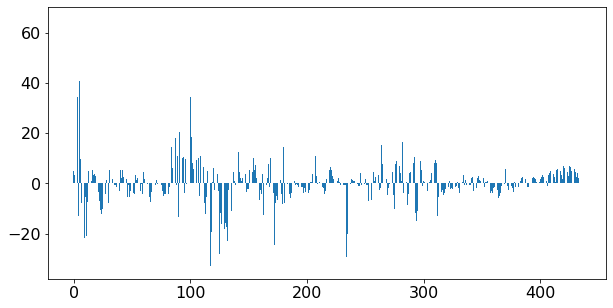

In [255]:
RidgeImp(x_inter_train_val, y_train_val,x_inter_test,y_test, ridge_best_alpha, plot_coef=True)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.386e+07, tolerance: 3.688e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.005) je selektovao 340 obelezja,a odbacio 95 obelezja


{'mse': 3445.7347496282573,
 'mae': 41.589313304242296,
 'rmse': 58.70038117106444,
 'r2': 0.5560693532507447,
 'r2_adj': 0.5517057823246138,
 'rss': 27176509.970318064}

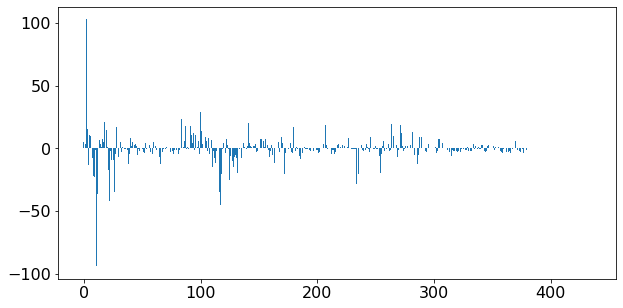

In [256]:
LassoImp(x_inter_train_val, y_train_val,x_inter_test,y_test, lasso_best_alpha, plot_coef=True)

#Hipoteza h<sub>3</sub>(**x**)
h<sub>3</sub>(**x**) = $\theta_0 + \theta_1 * x_1 + \theta_2 * x_2 + ... + \theta_n * x_n + \theta_{n+1} * x_1^2 + \theta_{n+2} * x_1x_2 + ... + \theta_{2n-1} * x_{n-1}x_n + \theta_{2n} * x_n^2$

In [257]:
x_inter_train, x_inter_val = PolyFeat(x_train_std, x_val_std, 2)

In [258]:
print(x_inter_train.shape)
print(y_train.shape)
print(x_inter_val.shape)
print(y_val.shape)

(36804, 464)
(36804,)
(7887, 464)
(7887,)


##Pronalazenje hiperparametara

###Ridge

In [259]:
alphas = [0.1,0.5,1,2,3,4,5,6,10,15,30,50,75,100,200]
ridge_results = train_models(x_inter_train, y_train, x_inter_val, y_val,alphas,'ridge')

In [260]:
ridge_r2_scores = [(key,val['r2']) for key,val in ridge_results.items()]
ridge_r2_scores = sorted(ridge_r2_scores,key = lambda x: x[1])
ridge_best_alpha = ridge_r2_scores[-1][0]
print(f'Maksimalni R2 skor ima model sa alfa = {ridge_best_alpha} ) -> R2 = {ridge_r2_scores[-1][1]}')

Maksimalni R2 skor ima model sa alfa = 0.5 ) -> R2 = 0.5421435876011658


In [261]:
ridge_r2_scores

[(200, 0.5405147868530614),
 (100, 0.5415312742014484),
 (75, 0.5417319308489953),
 (50, 0.5419025065165988),
 (30, 0.5420143323302729),
 (15, 0.5420843351384956),
 (10, 0.5421063376135609),
 (6, 0.5421241988716872),
 (5, 0.5421286575668726),
 (4, 0.5421330148440581),
 (3, 0.5421371235001731),
 (2, 0.5421406918807128),
 (1, 0.5421431319418568),
 (0.1, 0.5421433790215636),
 (0.5, 0.5421435876011658)]

In [262]:
#alphas_set = set(alphas)

###Lasso

In [263]:
alphas = [0.0005,0.001,0.005,0.01,0.05, 0.1, 0.2,0.5,1,2]
lasso_results = train_models(x_inter_train, y_train, x_inter_val, y_val,alphas,'lasso')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.549e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.0005) je selektovao 436 obelezja,a odbacio 28 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.504e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.001) je selektovao 418 obelezja,a odbacio 46 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.303e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.005) je selektovao 357 obelezja,a odbacio 107 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.432e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.01) je selektovao 325 obelezja,a odbacio 139 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.383e+06, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.05) je selektovao 263 obelezja,a odbacio 201 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.492e+06, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.1) je selektovao 241 obelezja,a odbacio 223 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.778e+06, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.2) je selektovao 224 obelezja,a odbacio 240 obelezja
Lasso(alpha = 0.5) je selektovao 162 obelezja,a odbacio 302 obelezja
Lasso(alpha = 1) je selektovao 122 obelezja,a odbacio 342 obelezja
Lasso(alpha = 2) je selektovao 68 obelezja,a odbacio 396 obelezja


In [264]:
lasso_r2_scores = [(key,val['r2']) for key,val in lasso_results.items()]
lasso_r2_scores = sorted(lasso_r2_scores,key = lambda x: x[1])
lasso_best_alpha = lasso_r2_scores[-1][0]
print(f'Maksimalni R2 skor ima model sa alfa = {lasso_best_alpha} ) -> R2 = {lasso_r2_scores[-1][1]}')

Maksimalni R2 skor ima model sa alfa = 0.005 ) -> R2 = 0.5423168227000081


In [265]:
lasso_r2_scores

[(2, 0.4227850622328181),
 (1, 0.4760761092228408),
 (0.5, 0.5116953164511904),
 (0.2, 0.5303961778012235),
 (0.1, 0.5377247193394337),
 (0.05, 0.5406331485396225),
 (0.01, 0.5422288642845328),
 (0.0005, 0.5422569311955769),
 (0.001, 0.5422735947011282),
 (0.005, 0.5423168227000081)]

##Test

In [266]:
x_inter_train_val, x_inter_test = PolyFeat(x_train_val_std, x_test_std, 2)

In [267]:
print(x_inter_train_val.shape)
print(y_train_val.shape)
print(x_inter_test.shape)
print(y_test.shape)

(44691, 464)
(44691,)
(7887, 464)
(7887,)


Mean squared error:  3405.237636364675
Mean absolute error:  41.42222988921396
Root mean squared error:  58.35441402640142
R2 score:  0.5612867919071937
R2 adjusted score:  0.5566840033087435
RSS 26857109.23800819
        y      y_pred
0    29.0   64.843994
1    20.0   23.426392
2   164.0  146.076660
3    14.0   78.663940
4    17.0   55.665405
5   129.0  139.414307
6    65.0  103.288635
7   338.0  248.649902
8     7.0    8.563721
9    81.0  110.047485
10  113.0  110.130127
11  172.0  162.154053
12  158.0  145.646240
13  204.0  148.490234
14  129.0  138.029053
15   11.0   32.347656
16   50.0   72.544189
17   13.0   40.497559
18  132.0   78.137268
19  150.0  203.456787
koeficijenti:  [ 4.39796127e+00  2.02464427e+00  7.25264126e+01  3.04531292e+01
 -1.33845348e+01  3.82653673e+01  8.03585791e+00 -1.35672575e+01
 -2.20740647e+01 -2.07015481e+01 -5.31012637e+11 -3.51576948e+11
 -2.17734200e+10 -7.16910506e+10  2.97488741e+11 -4.00026314e+11
 -4.83696564e+11 -4.11823415e+11  2.34982177e+11 

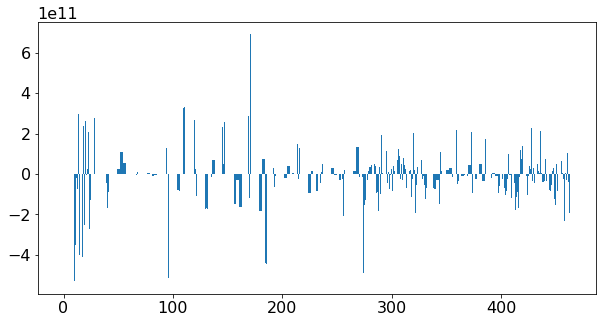

In [268]:
LinRegression(x_inter_train_val, y_train_val,x_inter_test,y_test,plot_coef=True)

In [269]:
ridge_best_alpha

0.5

{'mse': 3405.201857399651,
 'mae': 41.421844176391716,
 'rmse': 58.354107459540934,
 'r2': 0.5612914014840291,
 'r2_adj': 0.5566886612472586,
 'rss': 26856827.04931105}

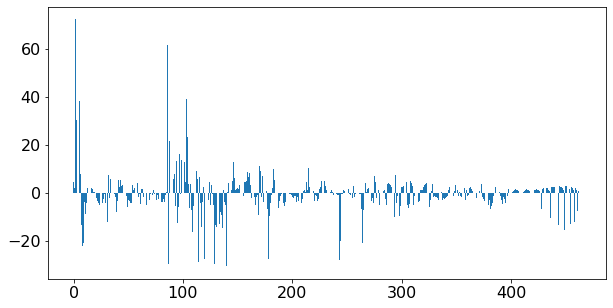

In [270]:
RidgeImp(x_inter_train_val, y_train_val,x_inter_test,y_test, ridge_best_alpha, plot_coef=True)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.718e+07, tolerance: 3.688e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.005) je selektovao 356 obelezja,a odbacio 108 obelezja


{'mse': 3405.7141537692023,
 'mae': 41.41516938142521,
 'rmse': 58.35849684295512,
 'r2': 0.5612253998689347,
 'r2_adj': 0.5566219671718603,
 'rss': 26860867.5307777}

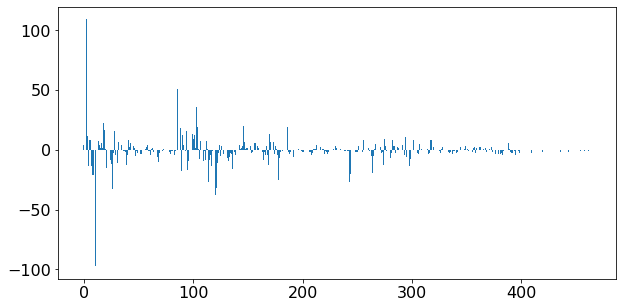

In [271]:
LassoImp(x_inter_train_val, y_train_val,x_inter_test,y_test, lasso_best_alpha, plot_coef=True)

#Hipoteza h<sub>4</sub>(**x**)
h<sub>4</sub>(**x**) =  $\theta_0 + \theta_1 * x_1 + \theta_2 * x_2 + ... + \theta_n * x_n + \theta_{n+1} * x_1^2 + \theta_{n+2} * x_1x_2 + ... + \theta_{2n-1} * x_{n-1}x_n + \theta_{2n} * x_n^2 + \theta_{2n+1} * x_1^3 + \theta_{2n+2} * x_1^2x_2 + ... + \theta_{3n-1} * x_{n-1}x_n^2 + \theta_{3n} * x_n^3$

In [274]:
x_inter_train, x_inter_val = PolyFeat(x_train_std, x_val_std, 3)

In [275]:
print(x_inter_train.shape)
print(x_inter_val.shape)

(36804, 4959)
(7887, 4959)


##Pronalazenje hiperparametara

###Ridge

In [276]:
alphas = [0.1,0.5,1,2,3,4,5,6,10,15,30,50,75,100,200,300,500]
ridge_results = train_models(x_inter_train, y_train, x_inter_val, y_val,alphas,'ridge')

In [277]:
ridge_r2_scores = [(key,val['r2']) for key,val in ridge_results.items()]
ridge_r2_scores = sorted(ridge_r2_scores,key = lambda x: x[1])
ridge_best_alpha = ridge_r2_scores[-1][0]
print(f'Maksimalni R2 skor ima model sa alfa = {ridge_best_alpha} ) -> R2 = {ridge_r2_scores[-1][1]}')

Maksimalni R2 skor ima model sa alfa = 500 ) -> R2 = 0.6185017335568999


In [278]:
ridge_r2_scores

[(0.1, 0.5120076651416547),
 (0.5, 0.5257802047328837),
 (1, 0.5338980464180325),
 (2, 0.5454315081227874),
 (3, 0.5537302672049164),
 (4, 0.5601002145931673),
 (5, 0.5651916042510993),
 (6, 0.5693799208952725),
 (10, 0.5808056979370684),
 (15, 0.5890489135025367),
 (30, 0.6004642589050753),
 (50, 0.6065607663489868),
 (75, 0.6102101999099154),
 (100, 0.6123002241919047),
 (200, 0.6160920462216934),
 (300, 0.6175916038215821),
 (500, 0.6185017335568999)]

In [279]:
#alphas_set = set(alphas)

###Lasso

In [280]:
alphas = [0.0005,0.001,0.005,0.01,0.05, 0.1, 0.2,0.5,1,2]
lasso_results = train_models(x_inter_train, y_train, x_inter_val, y_val,alphas,'lasso')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.893e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.0005) je selektovao 3593 obelezja,a odbacio 1366 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.910e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.001) je selektovao 3161 obelezja,a odbacio 1798 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.012e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.005) je selektovao 2337 obelezja,a odbacio 2622 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.094e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.01) je selektovao 1974 obelezja,a odbacio 2985 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.452e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.05) je selektovao 1254 obelezja,a odbacio 3705 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.797e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.1) je selektovao 1023 obelezja,a odbacio 3936 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.187e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.2) je selektovao 766 obelezja,a odbacio 4193 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.321e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.5) je selektovao 470 obelezja,a odbacio 4489 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.447e+07, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 1) je selektovao 310 obelezja,a odbacio 4649 obelezja
Lasso(alpha = 2) je selektovao 179 obelezja,a odbacio 4780 obelezja


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.549e+05, tolerance: 3.024e+04
  model = cd_fast.enet_coordinate_descent(


In [281]:
lasso_r2_scores = [(key,val['r2']) for key,val in lasso_results.items()]
lasso_r2_scores = sorted(lasso_r2_scores,key = lambda x: x[1])
lasso_best_alpha = lasso_r2_scores[-1][0]
print(f'Maksimalni R2 skor ima model sa alfa = {lasso_best_alpha} ) -> R2 = {lasso_r2_scores[-1][1]}')

Maksimalni R2 skor ima model sa alfa = 0.05 ) -> R2 = 0.633781164112746


In [282]:
lasso_results

{0.0005: {'mse': 3173.4544218889137,
  'mae': 37.257305737188986,
  'rmse': 56.33342189046316,
  'r2': 0.6226265329433964,
  'r2_adj': 0.5638589464864909,
  'rss': 25029035.02543786},
 0.001: {'mse': 3162.153874237295,
  'mae': 37.1989036863984,
  'rmse': 56.233031878401285,
  'r2': 0.6239703451681806,
  'r2_adj': 0.5654120277987864,
  'rss': 24939907.606109545},
 0.005: {'mse': 3118.543920495006,
  'mae': 36.96899617257222,
  'rmse': 55.84392465161279,
  'r2': 0.629156252149668,
  'r2_adj': 0.571405525306627,
  'rss': 24595955.900944114},
 0.01: {'mse': 3086.091602655515,
  'mae': 36.857015625408025,
  'rmse': 55.55260212317255,
  'r2': 0.6330153413531052,
  'r2_adj': 0.5758655824588096,
  'rss': 24340004.47014405},
 0.05: {'mse': 3079.6515536453903,
  'mae': 36.99062081469671,
  'rmse': 55.494608329507024,
  'r2': 0.633781164112746,
  'r2_adj': 0.5767506652066761,
  'rss': 24289211.803601194},
 0.1: {'mse': 3144.6588637896984,
  'mae': 37.32324262589743,
  'rmse': 56.07725799100468,


##Test


In [283]:
x_inter_train_val, x_inter_test = PolyFeat(x_train_val_std, x_test_std, 3)

In [284]:
print(x_inter_train_val.shape)
print(y_train_val.shape)
print(x_inter_test.shape)
print(y_test.shape)

(44691, 4959)
(44691,)
(7887, 4959)
(7887,)


Mean squared error:  3135.2482489023464
Mean absolute error:  36.83359341381378
Root mean squared error:  55.99328753433171
R2 score:  0.5960708284336609
R2 adjusted score:  0.5456546606604491
RSS 24727702.939092807
        y      y_pred
0    29.0   -6.471250
1    20.0   13.432289
2   164.0  126.790375
3    14.0   64.047330
4    17.0   66.410059
5   129.0   83.848703
6    65.0   95.117956
7   338.0  294.487626
8     7.0   15.796197
9    81.0  120.383924
10  113.0   76.683840
11  172.0  125.748682
12  158.0  145.064378
13  204.0  168.776548
14  129.0  167.236221
15   11.0   17.273176
16   50.0   81.559316
17   13.0   30.529521
18  132.0  109.128751
19  150.0  168.056457
koeficijenti:  [ 5.29102221e+00  2.12420699e+07 -3.36119736e+08 ...  6.97349045e+08
 -8.30109080e+07  2.32343021e+09]


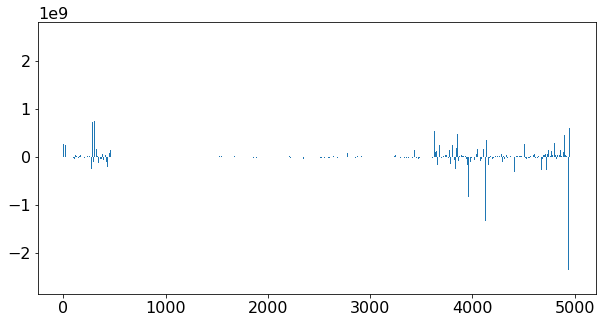

In [285]:
LinRegression(x_inter_train_val, y_train_val,x_inter_test,y_test,plot_coef=True)

In [286]:
ridge_best_alpha

500

{'mse': 2785.9941086611902,
 'mae': 36.454498467319375,
 'rmse': 52.78251707394401,
 'r2': 0.6410669258186492,
 'r2_adj': 0.5962669178937211,
 'rss': 21973135.535010807}

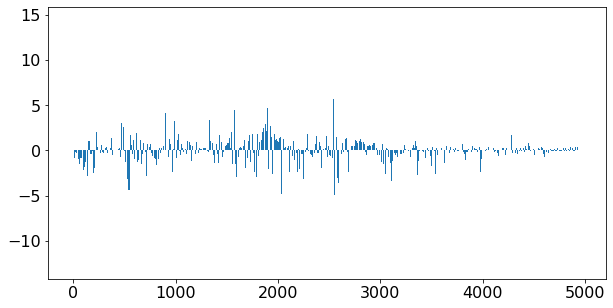

In [287]:
RidgeImp(x_inter_train_val, y_train_val,x_inter_test,y_test,ridge_best_alpha, plot_coef=True)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.726e+07, tolerance: 3.688e+04
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha = 0.05) je selektovao 1241 obelezja,a odbacio 3718 obelezja


{'mse': 2725.109461034287,
 'mae': 36.28057559632428,
 'rmse': 52.202580980582624,
 'r2': 0.648910988975579,
 'r2_adj': 0.6050900329042467,
 'rss': 21492938.319177423}

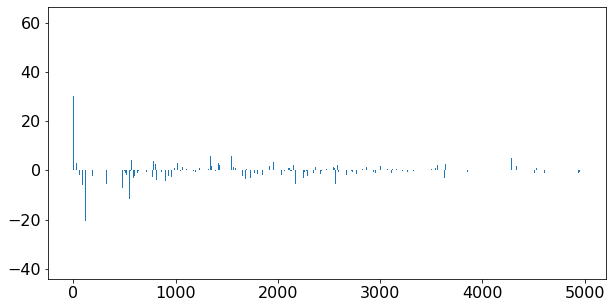

In [288]:
LassoImp(x_inter_train_val, y_train_val,x_inter_test,y_test, lasso_best_alpha, plot_coef=True)

#Hipoteza h<sub>5</sub>(**x**)
h<sub>5</sub>(**x**) =  $\theta_0 + \theta_1 * x_1 + \theta_2 * x_2 + ... + \theta_n * x_n + \theta_{n+1} * x_1^2 + \theta_{n+2} * x_1x_2 + ... + \theta_{2n-1} * x_{n-1}x_n + \theta_{2n} * x_n^2 + \theta_{2n+1} * x_1^3 + \theta_{2n+2} * x_1^2x_2 + ... + \theta_{3n-1} * x_{n-1}x_n^2 + \theta_{3n} * x_n^3 + \theta_{3n+1} * x_1^4 + ... + \theta_{4n} * x_n^4$



In [49]:
x_inter_train, x_inter_val = PolyFeat(x_train_std, x_val_std, 4,True)

In [50]:
# #Nedovoljno rama
# del Iprec_filler,X,ax,categorical_features,corr,df,df_nulls,fall_description,fiftheen_percent,groupedByWindDirection,heatmap,humi_filler,i,krtosis,matrix,missing_values_columns,model,nullValues,numeric_features,plot,pm25,prec_filler,pres_filler,skewness,spring_description,summer_description,temp,winter_description,x,x_temp,x_test,x_train,x_train_std,x_train_val,x_val,x_val_std,y

NameError: ignored

In [52]:
print(x_inter_train.shape)
print(x_inter_val.shape)

(36804, 27840)
(7887, 27840)


##Pronalazenje hiperparametara

###Ridge

In [ ]:
alphas = [0.1,0.5,1,2,3,4,5,6,10,15,30,50,75,100,200]
ridge_results = train_models(x_inter_train, y_train, x_inter_val, y_val,alphas,'ridge')

In [ ]:
ridge_r2_scores = [(key,val['r2']) for key,val in ridge_results.items()]
ridge_r2_scores = sorted(ridge_r2_scores,key = lambda x: x[1])
ridge_best_alpha = ridge_r2_scores[-1][0]
print(f'Maksimalni R2 skor ima model sa alfa = {ridge_best_alpha} ) -> R2 = {ridge_r2_scores[-1][1]}')

In [ ]:
ridge_r2_scores

In [ ]:
#alphas_set = set(alphas)

###Lasso

In [ ]:
alphas = [0.0005,0.001,0.005,0.01,0.05, 0.1, 0.2,0.5,1,2]
lasso_results = train_models(x_inter_train, y_train, x_inter_val, y_val,alphas,'lasso')

In [ ]:
lasso_r2_scores = [(key,val['r2']) for key,val in lasso_results.items()]
lasso_r2_scores = sorted(lasso_r2_scores,key = lambda x: x[1])
lasso_best_alpha = lasso_r2_scores[-1][0]
print(f'Maksimalni R2 skor ima model sa alfa = {lasso_best_alpha} ) -> R2 = {lasso_r2_scores[-1][1]}')

In [ ]:
lasso_results

##Test


In [ ]:
x_inter_train_val, x_inter_test = PolyFeat(x_train_val_std, x_test_std, 4)

In [ ]:
print(x_inter_train_val.shape)
print(y_train_val.shape)
print(x_inter_test.shape)
print(y_test.shape)

In [ ]:
LinRegression(x_inter_train_val, y_train_val,x_inter_test,y_test,plot_coef=True)

In [ ]:
ridge_best_alpha

In [ ]:
RidgeImp(x_inter_train_val, y_train_val,x_inter_test,y_test, ridge_best_alpha, plot_coef=True)

In [ ]:
LassoImp(x_inter_train_val, y_train_val,x_inter_test,y_test, lasso_best_alpha, plot_coef=True)

#KNN

In [134]:
df['category'] = pd.cut(df['pm25'], bins=[-np.inf, 55.4, 150.4, np.inf], labels=['safe', 'unsafe','dangerous'])

In [135]:
df.groupby('category').count()['pm25']

category
safe         22126
unsafe       19983
dangerous    10469
Name: pm25, dtype: int64

In [136]:
x = df.drop(['category','pm25'],axis = 1)
y = df['category']

In [137]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 33,stratify=y)
x_train, x_test = std(x_train, x_test)

In [138]:
x_train.describe()

,day,hour,dew_temp,humidity,air_pressure,temp,wind_direction,cumulative_wind_speed,precipitation,cumulative_precipitation,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
count,4.469100e+04,4.469100e+04,4.469100e+04,4.469100e+04,4.469100e+04,4.469100e+04,4.469100e+04,4.469100e+04,4.469100e+04,4.469100e+04,...,4.469100e+04,4.469100e+04,4.469100e+04,4.469100e+04,4.469100e+04,4.469100e+04,4.469100e+04,4.469100e+04,4.469100e+04,4.469100e+04
mean,-4.753805e-17,7.806415e-17,1.001638e-17,-2.109799e-16,-6.339890e-15,-1.089082e-17,7.464586e-17,2.130468e-17,1.947629e-17,5.246674e-18,...,8.267486e-18,-4.729956e-17,9.563256e-17,-5.532856e-17,-2.321256e-17,-4.833300e-17,6.041624e-18,-5.246674e-17,-4.992290e-17,4.404026e-17
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,...,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00
min,-1.671557e+00,-1.662935e+00,-2.963994e+00,-2.030826e+00,-2.479911e+00,-2.612465e+00,-1.273094e+00,-4.625615e-01,-7.346231e-02,-8.042587e-02,...,-2.883216e-01,-3.046250e-01,-3.004835e-01,-3.038787e-01,-2.985318e-01,-3.059826e-01,-3.050633e-01,-2.981315e-01,-3.059826e-01,-2.985762e-01
25%,-8.772437e-01,-7.960376e-01,-8.522726e-01,-8.733497e-01,-8.265605e-01,-8.768843e-01,-1.273094e+00,-4.353855e-01,-7.346231e-02,-8.042587e-02,...,-2.883216e-01,-3.046250e-01,-3.004835e-01,-3.038787e-01,-2.985318e-01,-3.059826e-01,-3.050633e-01,-2.981315e-01,-3.059826e-01,-2.985762e-01
50%,3.054239e-02,7.085934e-02,-7.583883e-03,1.404871e-02,-4.851302e-02,1.148762e-01,4.691577e-01,-3.719073e-01,-7.346231e-02,-8.042587e-02,...,-2.883216e-01,-3.046250e-01,-3.004835e-01,-3.038787e-01,-2.985318e-01,-3.059826e-01,-3.050633e-01,-2.981315e-01,-3.059826e-01,-2.985762e-01
75%,8.248552e-01,7.932735e-01,9.074955e-01,9.014471e-01,8.267904e-01,8.586965e-01,4.691577e-01,-4.539012e-02,-7.346231e-02,-8.042587e-02,...,-2.883216e-01,-3.046250e-01,-3.004835e-01,-3.038787e-01,-2.985318e-01,-3.059826e-01,-3.050633e-01,-2.981315e-01,-3.059826e-01,-2.985762e-01
max,1.732641e+00,1.660170e+00,1.822575e+00,1.750263e+00,2.869165e+00,2.428984e+00,1.340283e+00,1.140462e+01,7.809837e+01,5.513974e+01,...,3.468349e+00,3.282725e+00,3.327970e+00,3.290786e+00,3.349727e+00,3.268160e+00,3.278008e+00,3.354225e+00,3.268160e+00,3.349229e+00


In [139]:
x_train.head(10)

,day,hour,dew_temp,humidity,air_pressure,temp,wind_direction,cumulative_wind_speed,precipitation,cumulative_precipitation,...,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
0,-0.877244,-1.373969,1.189058,0.901447,-0.632049,0.858697,0.469158,-0.435386,-0.073462,-0.080426,...,-0.288322,-0.304625,-0.300483,-0.303879,-0.298532,3.268160,-0.305063,-0.298132,-0.305983,-0.298576
1,-0.309877,-1.229486,-0.429928,0.978612,1.118558,-1.124824,1.340283,-0.453638,-0.073462,-0.080426,...,-0.288322,-0.304625,-0.300483,-0.303879,-0.298532,-0.305983,-0.305063,-0.298132,-0.305983,-0.298576
2,-0.536824,1.515688,0.485151,1.248690,0.729534,-0.133064,-1.273094,-0.371907,10.432290,2.692964,...,-0.288322,-0.304625,3.327970,-0.303879,-0.298532,-0.305983,-0.305063,-0.298132,-0.305983,-0.298576
3,1.732641,1.226722,1.400231,0.554204,-1.118328,1.271930,0.469158,0.272001,-0.073462,-0.080426,...,-0.288322,-0.304625,-0.300483,-0.303879,-0.298532,3.268160,-0.305063,-0.298132,-0.305983,-0.298576
4,0.597909,0.070859,-0.922663,-1.336340,0.924046,-0.133064,1.340283,-0.453638,-0.073462,-0.080426,...,-0.288322,-0.304625,-0.300483,-0.303879,-0.298532,-0.305983,-0.305063,-0.298132,-0.305983,3.349229
5,-0.763770,0.504308,-1.626571,-1.490670,0.729534,-0.876884,0.469158,-0.290379,-0.073462,-0.080426,...,3.468349,-0.304625,-0.300483,-0.303879,-0.298532,-0.305983,-0.305063,-0.298132,-0.305983,-0.298576
6,-1.217663,0.504308,-0.781882,-1.645001,-0.145769,0.693403,-1.273094,-0.290379,-0.073462,-0.080426,...,-0.288322,-0.304625,-0.300483,3.290786,-0.298532,-0.305983,-0.305063,-0.298132,-0.305983,-0.298576
7,1.619168,0.793273,1.329840,1.518768,-1.118328,0.776050,-0.401968,-0.390160,-0.073462,-0.080426,...,-0.288322,-0.304625,-0.300483,-0.303879,-0.298532,3.268160,-0.305063,-0.298132,-0.305983,-0.298576
8,-0.990717,0.359825,0.062807,-1.259175,-1.021072,1.106637,1.340283,-0.399083,-0.073462,-0.080426,...,-0.288322,-0.304625,-0.300483,3.290786,-0.298532,-0.305983,-0.305063,-0.298132,-0.305983,-0.298576
9,0.030542,-0.651555,-0.289147,1.750263,1.118558,-1.207471,0.469158,0.035732,-0.073462,-0.080426,...,-0.288322,-0.304625,-0.300483,-0.303879,-0.298532,-0.305983,-0.305063,-0.298132,-0.305983,-0.298576


In [140]:
print(y_train.groupby(y_train).count())
print(y_test.groupby(y_test).count())

category
safe         18807
unsafe       16985
dangerous     8899
Name: category, dtype: int64
category
safe         3319
unsafe       2998
dangerous    1570
Name: category, dtype: int64


In [141]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors':[1,3,5,7,9,11,13,15], 'metric':('manhattan','euclidean','jaccard')}

    
# defining parameter range
grid = GridSearchCV(knn,parameters,cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), scoring='recall_micro')
  
# fitting the model for grid search
grid.fit(x_train, y_train)
print(grid.best_score_)
print(grid.best_params_)
print(grid.scoring)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/

0.8400348811073849
{'metric': 'manhattan', 'n_neighbors': 1}
recall_micro


[{'metric': 'manhattan', 'n_neighbors': 1}, {'metric': 'manhattan', 'n_neighbors': 3}, {'metric': 'manhattan', 'n_neighbors': 5}, {'metric': 'manhattan', 'n_neighbors': 7}, {'metric': 'manhattan', 'n_neighbors': 9}, {'metric': 'manhattan', 'n_neighbors': 11}, {'metric': 'manhattan', 'n_neighbors': 13}, {'metric': 'manhattan', 'n_neighbors': 15}, {'metric': 'euclidean', 'n_neighbors': 1}, {'metric': 'euclidean', 'n_neighbors': 3}, {'metric': 'euclidean', 'n_neighbors': 5}, {'metric': 'euclidean', 'n_neighbors': 7}, {'metric': 'euclidean', 'n_neighbors': 9}, {'metric': 'euclidean', 'n_neighbors': 11}, {'metric': 'euclidean', 'n_neighbors': 13}, {'metric': 'euclidean', 'n_neighbors': 15}, {'metric': 'jaccard', 'n_neighbors': 1}, {'metric': 'jaccard', 'n_neighbors': 3}, {'metric': 'jaccard', 'n_neighbors': 5}, {'metric': 'jaccard', 'n_neighbors': 7}, {'metric': 'jaccard', 'n_neighbors': 9}, {'metric': 'jaccard', 'n_neighbors': 11}, {'metric': 'jaccard', 'n_neighbors': 13}, {'metric': 'jacc

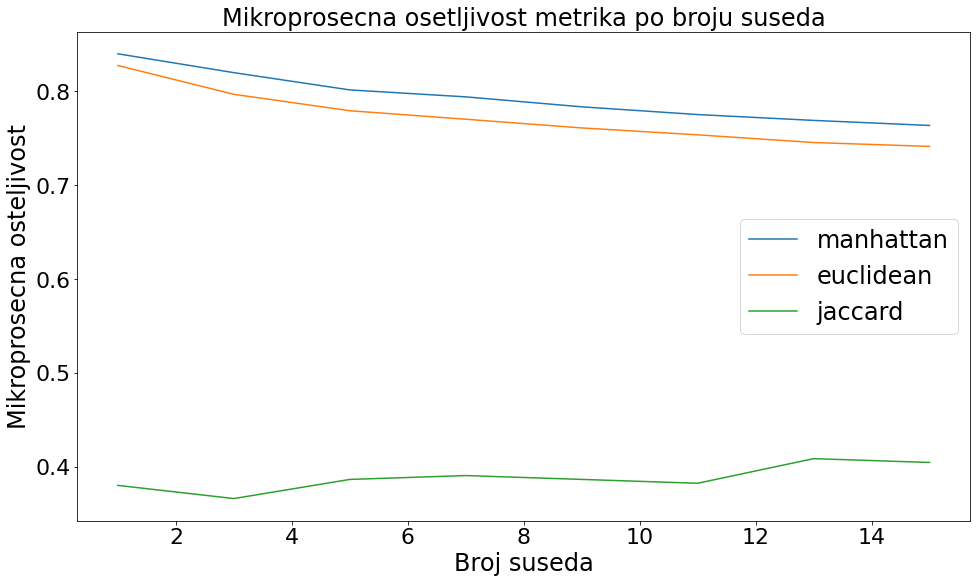

In [167]:
params = grid.cv_results_['params']
results = (grid.cv_results_['mean_test_score'])


plt.figure(figsize=[16,9])
sns.lineplot(x=[i['n_neighbors'] for i in params],y=results,hue = [i['metric'] for i in params])
plt.title("Mikroprosecna osetljivost metrika po broju suseda",fontsize = 24)
plt.xlabel("Broj suseda",fontsize = 24)
plt.ylabel("Mikroprosecna osteljivost",fontsize = 24)
plt.legend(fontsize=24)

Unakrsna validacija sa optimalnim parametrima

In [143]:
def evaluation_classif(cm, class_num):
    TP = cm[class_num][class_num]
    FP = np.sum(cm[:, class_num]) - TP
    FN = np.sum(cm[class_num, :]) - TP
    TN = np.sum(cm) - (FP + FN + TP)
    precision = TP/(TP+FP)
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    f_score = 2*TP/(2*TP+FP+FN)
    accuracy = (TP+TN)/(TP+FP+FN+TN)
    print('Tacnost',accuracy)
    print('Preciznost:', precision )
    print('Senzitivnost:', sensitivity )
    print('Specificnost:', specificity )
    print('f_score:', f_score )

In [169]:
conf_mat = np.zeros((len(np.unique(y_train)),len(np.unique(y_train))))
indexes = StratifiedKFold(n_splits=10, shuffle=True, random_state=42).split(x_train, y_train)
micro_recall = []
for train_index, test_index in indexes:
    classifier = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
    classifier.fit(x_train.iloc[train_index,:], y_train.iloc[train_index])
    y_pred = classifier.predict(x_train.iloc[test_index,:])
    micro_recall.append(recall_score(y_train.iloc[test_index], y_pred,average = 'micro'))
    conf_mat += confusion_matrix(y_train.iloc[test_index], y_pred, labels=classifier.classes_)

Mere uspesnosti po klasama:

Dangerous:
Tacnost 0.9308585621266027
Preciznost: 0.8218282548476454
Senzitivnost: 0.8334644342060906
Specificnost: 0.9550737594993295
f_score: 0.8276054452131221

Safe:
Tacnost 0.9009867758609116
Preciznost: 0.8863221231331256
Senzitivnost: 0.8772265645770192
Specificnost: 0.918250656776387
f_score: 0.8817508885385211

Unsafe:
Tacnost 0.848224474726455
Preciznost: 0.7991437954492142
Senzitivnost: 0.8022961436561672
Specificnost: 0.8763805673861258
f_score: 0.8007168669389194

Prosecna mikroprosečna osetljivost: 0.8400348811073849
Matrica konfuzije:


<Figure size 648x648 with 0 Axes>

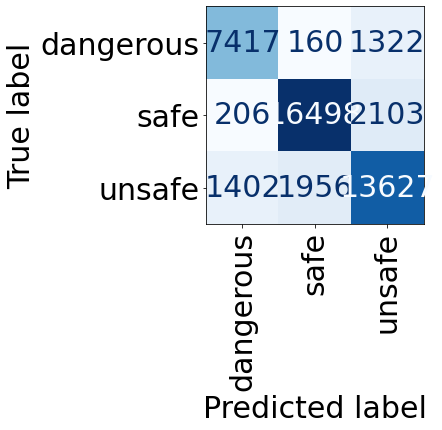

In [170]:
print('Mere uspesnosti po klasama:\n')
print('Dangerous:')
evaluation_classif(conf_mat,0)
print('\nSafe:')
evaluation_classif(conf_mat,1)
print('\nUnsafe:')
evaluation_classif(conf_mat,2)

print('\nProsecna mikroprosečna osetljivost:', np.mean(micro_recall))
print('Matrica konfuzije:')
plt.figure(figsize = [9,9])
cmatrix = ConfusionMatrixDisplay(confusion_matrix =conf_mat,  display_labels=classifier.classes_)
cmatrix.plot(cmap="Blues", values_format='.5g', xticks_rotation=90,colorbar = False)  
plt.show()

In [146]:
print('Dangerous:')
evaluation_classif(conf_mat,0)
print('\nSafe:')
evaluation_classif(conf_mat,1)
print('\nUnsafe:')
evaluation_classif(conf_mat,2)

Dangerous:
Tacnost 0.9308585621266027
Preciznost: 0.8218282548476454
Senzitivnost: 0.8334644342060906
Specificnost: 0.9550737594993295
f_score: 0.8276054452131221

Safe:
Tacnost 0.9009867758609116
Preciznost: 0.8863221231331256
Senzitivnost: 0.8772265645770192
Specificnost: 0.918250656776387
f_score: 0.8817508885385211

Unsafe:
Tacnost 0.848224474726455
Preciznost: 0.7991437954492142
Senzitivnost: 0.8022961436561672
Specificnost: 0.8763805673861258
f_score: 0.8007168669389194


Testiranje nad testnim skupom

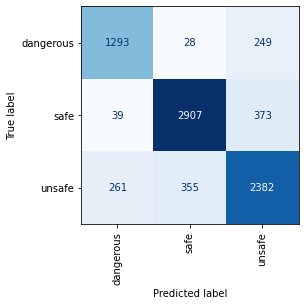

In [150]:
knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
conf_mat = confusion_matrix(y_test, y_pred)

conf_mat = confusion_matrix(y_test, y_pred, labels=classifier.classes_)

cmatrix  = ConfusionMatrixDisplay(confusion_matrix =conf_mat,  display_labels=classifier.classes_)
cmatrix.plot(cmap="Blues", values_format='.5g', xticks_rotation=90,colorbar = False)  
plt.show()

In [148]:
print('Dangerous:')
evaluation_classif(conf_mat,0)
print('\nSafe:')
evaluation_classif(conf_mat,1)
print('\nUnsafe:')
evaluation_classif(conf_mat,2)

Dangerous:
Tacnost 0.9268416381387092
Preciznost: 0.8116760828625236
Senzitivnost: 0.8235668789808918
Specificnost: 0.9525091024220358
f_score: 0.8175782484982611

Safe:
Tacnost 0.899201217192849
Preciznost: 0.8835866261398176
Senzitivnost: 0.8758662247664959
Specificnost: 0.9161558669001751
f_score: 0.8797094870630958

Unsafe:
Tacnost 0.8430328388487385
Preciznost: 0.7929427430093209
Senzitivnost: 0.7945296864576384
Specificnost: 0.8727756187359378
f_score: 0.793735421526158


In [149]:
print('Tačnost: ', accuracy_score(y_test, y_pred))
print('Mikro preciznost: ', precision_score(y_test, y_pred, average='micro'))
print('Makro preciznost: ', precision_score(y_test, y_pred, average='macro'))
print('Mikro osetljivost: ', recall_score(y_test, y_pred, average='micro'))
print('Makro osetljivost: ', recall_score(y_test, y_pred, average='macro'))
print('Mikro f mera : ', f1_score(y_test, y_pred, average='micro'))
print('Makro f mera: ', f1_score(y_test, y_pred, average='macro'))

Tačnost:  0.8345378470901483
Mikro preciznost:  0.8345378470901483
Makro preciznost:  0.8294018173372207
Mikro osetljivost:  0.8345378470901483
Makro osetljivost:  0.8313209300683421
Mikro f mera :  0.8345378470901483
Makro f mera:  0.8303410523625049
